# Машинное обучение в экономике 🙇

## Генерация и предварительная обработка данных 🤪

In [ ]:
%%capture
!pip install bnlearn
!pip install catboost
!pip install causalinference
!pip install doubleml

Установка библиотек

In [ ]:
# Подключим необходимые библиотеки
import numpy as np
import pandas as pd
import scipy as scipy
from copy import deepcopy
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.stats import t, chi2, f, norm, poisson, binom, uniform, expon, logistic
import seaborn
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier       # случайный лес (классификация)
from sklearn.ensemble import RandomForestRegressor        # случайный лес (регрессия)
from sklearn.ensemble import GradientBoostingClassifier   # градиентный бустинг (классификация)
from sklearn.ensemble import GradientBoostingRegressor    # градиентный бустинг (регрессия)
import statsmodels.api as sm                              # линейная регрессия
from sklearn.linear_model import LogisticRegression       # логистическая регрессия
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
import bnlearn
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor         #метод ближайших соседей (регрессия)
import doubleml as dml

**Описание сюжета** 😸

**Целевая переменная** - цена авиабилета (в долларах)   $\text{Ticket_Price}_{i}$.

**Переменная воздействия** - количество свободных мест  $\text{Last_ticket}_{i}$ (1 - свободных мест меньше 20, 0 - иначе).

**Инструментальная переменная** - время вылета в «час пик»  $\text{Hours}_{i}$ (1 - вылет в "час пик", 0 - нет).

**Контрольные переменные**:

*   $\text{Days_Before }_{i}$ - количество дней перед датой рейса.
*   $\text{Distance  }_{i}$ - расстояние (км).
*   $\text{Connection }_{i}$ - прямой рейс (1 - прямой рейс , 0 - с пересадками).

**Ненаблюдаемые переменные, порождающие эндогенность**:

*  $\text{Population }_{i}$ - средняя численность населения в городах отправления (тыс./чел.).






**Генерация контрольных переменных** 😸

Будем генерировать количество дней до даты рейса $\text{Days_Before}_{i}$ , взяв за основу распределение Пуассона $\text{P}(60)$.

In [ ]:
# Число наблюдений
n = 100000

In [ ]:
np.random.seed(11)
# Предположим, что распределение количества дней до вылета схоже с пуассоновским

# Генерация значений из пуассоновского распределения
Days_Before = poisson.rvs(mu = 60, size = n)

# Ограничение значений на диапазон [0, 365]
Days_Before = np.clip(Days_Before, 0, 365)

# Посмотрим на несколько первых значений
print(Days_Before[0:10])

[52 59 58 65 71 51 56 66 56 49]


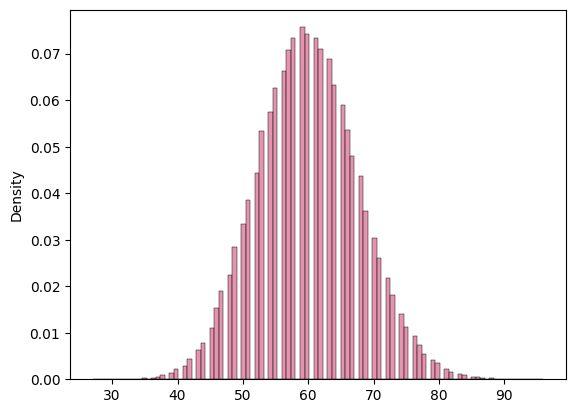

In [ ]:
# Посмотрим на распределение
seaborn.histplot(Days_Before,                 # данные
                 stat = 'density',           # тип гистограммы
                 color = "palevioletred",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins = 100);                 # число столбиков в Гистограмме

Будем генерировать расстояние $\text{Distance}_{i}$ , взяв за основу нормальное распределение с математическим ожиданием $\mu=1000$ и стандартным отклонением $\sigma=300$, то есть $\text{N}\left(25, 300^2\right)$.

In [ ]:
np.random.seed(11)
# Предположим, что распределение расстояния схоже с нормальным
Distance    = norm.rvs(size = n, loc = 1000, scale = 300)

# Для красоты ограничим минимальныезначения
Distance   [Distance    <= 24]  = 24

# Также, для удобства введем округление
Distance    = np.round(Distance)

# Посмотрим на несколько первых значений
print(Distance   [0:10])

[1525.  914.  855.  204.  998.  904.  839. 1095. 1126.  680.]


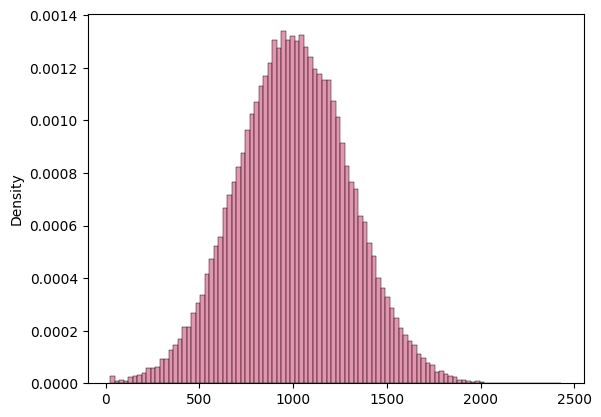

In [ ]:
# Посмотрим на распределение
seaborn.histplot(Distance  ,                 # данные
                 stat = 'density',           # тип гистограммы
                 color = "palevioletred",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins = 100);                 # число столбиков в Гистограмме

Поскольку $\text{Connection }_{i}$ является бинарной переменной, принимающей значения $0$ и $1$, то она имеет распределение Бернулли $\text{City}_{i}\sim\text{Ber}(p)$. Предположим, что количество прямых рейсов составляет $40\%$, откуда $p=0.4$.

In [ ]:
np.random.seed(11)
# Сгенерируем переменную на факт наличия пересадок у рейса
Connection  = np.random.binomial(n = 1, p = 0.4, size = n)

# Посмотрим на первые несколько значение
print(Connection [0:10])

[0 0 0 1 0 0 0 0 1 1]


In [ ]:
# Доля рейсов с пересадками
print(np.mean(Connection ))

0.40129


**Генерация ненаблюдаемой переменной, порождающей эндогенность** 😸

Сгенерируем среднюю численность населения в городах отправления $\text{Population }_{i}$ взяв за основу распределение Стьюдента с $5$ степенями свободы.

Эта переменная будет играть роль ненаблюдаемой, отсутствие в данных которой и приводит к проблеме эндогенности.

In [ ]:
np.random.seed(11)
# Генерируем среднюю численность населения в городах отправления (в тысячах чел.)
Population  = t.rvs(size = n, df = 5)

# Приведем её к более удобной шкале
Population  = (Population ) * 200 + 500

# Также, для удобства введем округление и возьмем модуль
Population  = np.round(np.abs(Population ) + 1)

# Для удобства ограничим минимальные значения
Population [Population  <= 11]   = 11
# Посмотрим на несколько первых значений
print(Population [0:10])

[917. 432. 397. 461. 275. 421. 601. 142. 600. 165.]


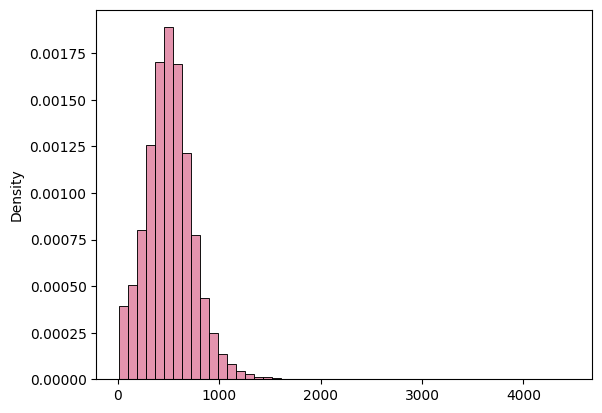

In [ ]:
# Посмотрим на распределение
seaborn.histplot(Population ,                  # данные
                 stat  = 'density',          # тип гистограммы
                 color = "palevioletred",    # цвет гистограммы
                 label = "histogram",        # наименование гистограммы
                 bins  = 50);                 # число столбиков в Гистограмме

**Генерация инструментальной переменной** 😸

Для того, чтобы сгенерировать бинарную переменную как функцию от других переменных, необходимо сперва предположить форму условных вероятностей. Для этого удобно применять следующий алгоритм:

1.   Записать **индекс**, который отражает статистические связи инструментальной переменной с контрольными переменными.
2.   Сформировать условные вероятности взяв функцию распределения от этого индекса

Например, предположим, что условная вероятность времени вылета в "час пик" положительно связана с расстоянием и типом рейса (прямой или с пересадками) и отрицательно с количеством дней до вылета:

$$\text{P}\left(\text{Hours}_{i} = 1|\text{Days_Before}_{i}, \text{Distance}_{i}, \text{Connection}_{i}\right) = \Phi\left(\underbrace{\frac{0.4 \times \text{Distance}_{i} - 0.3 \times \text{Days_Before}_{i} + 0.1 \times \text{Connection}_{i}}{100} - 3.8}_{\text{индекс}}\right)$$

Где $\Phi()$ - функция распределения стандартного нормального распределения.

Для удобства генерации мы предполагаем, что условные вероятности инструментальной переменной зависят лишь от контрольных переменных.

In [ ]:
# Сформируем индекс
index = (0.4 * Distance - 0.3 * Days_Before + 0.1 * Connection) / 100 - 3.8

In [ ]:
np.random.seed(11)
# Создадим условные вероятности
Hours_prob = norm.cdf(index)

# Посмотрим на несколько первых условных вероятностей
print(Hours_prob[0:10])

[9.83983557e-01 3.74105195e-01 2.89789423e-01 7.41473754e-04
 4.91622828e-01 3.68058450e-01 2.70268879e-01 6.48769318e-01
 7.04366193e-01 1.10099338e-01]


In [ ]:
np.random.seed(11)
# Сгенерируем перемнную, отвечающую за вылет в час-пик
Hours = np.random.binomial(n = 1, p = Hours_prob, size = n)

# Посмотрим на несколько сгенерированных значений
print(Hours)

[1 0 0 ... 1 1 0]


Желательно, чтобы дисперсия индекса отличалась от дисперсии распределения, чья функция распределения используется на втором шаге алгоритма, не более, чем в $2$ раза. В противном случае оценки параметров такой модели могут оказаться либо слишком точными, либо слишком неточными.

В нашем случае использовалось стандарнтое нормальное распределение, поэтому дисперсия индекса должна быть около 1 (или превышать 1 не более, чем в 2 раза).

In [ ]:
# Дисперсия индекса
print(np.var(index).round(2))

1.44


Отлично!😛 Теперь убедимся, что доля единиц в сформированной переменной является адекватной.

In [ ]:
# Доля авиарейсов с вылетом в час-пик
print(np.mean(Hours))

0.5074


**Генерация переменной воздействия** 😸

Удобно предположить, что условные вероятности переменной воздействия зависят от контрольных переменных, инструментальной переменной и ненаблюдаемой переменной.

$$P(\text{Last_ticket}_{i} = 1|\text{Days_Before}_{i}, \text{Distance}_{i}, \text{Connection }_{i}, \text{Population}_{i}, \text{Hours}_{i}) = \\ = F_{\text{Logistic}}\left(\ln\left(\text{Days_Before}_{i} + 1\right) + 0.05\times \sqrt{\text{Distance}_{i}} - 2\times \text{Connection}_{i} + 2\times \ln\left(\text{Population}_{i} + 1\right) + 3 \times \text{Hours}_{i} - 18.5 \right)$$

Где $F_{\text{Logistic}}$ - функция распределения стандартного логистического распределения.

Для краткости введем обозначение для условной вероятности количества свободных мест в самолёте при конкретном времени вылета (в "час пик" или нет):

$$p_{k}^{\text{Hours}_{i}} = P(\text{Last_ticket}_{i} = 1|\text{Days_Before}_{i}, \text{Distance}_{i}, \text{Connection }_{i}, \text{Population}_{i}, \text{Hours}_{i} = k)\text{, где }k\in\{0,1\}$$

Для того, чтобы впоследствии анализировать локальные средние эффекты воздействия $\text{LATE}$, необходимо различать величину переменной воздействия $\text{Last_ticket}_{i}$ в зависимости от значения инструмента $\text{Hours}_{i}$. Для этого рассмотрим ни от чего не зависящую равномерную случайную величину $U_{i}\sim U(0,1)$ и введем гипотетические переменные:

$$\text{Last_ticket}_{1i} = I(p_{1}^{\text{Hours}_{i}}\geq U_{i})$$

$$\text{Last_ticket}_{0i} = I(p_{0}^{\text{Hours}_{i}}\geq U_{i})$$


$$I(\text{условие}) = \begin{cases}1\text{, если условие выполнено}\\0\text{, в противном случае}\end{cases}$$

Переменные $\text{Last_ticket}_{1i}$ и $\text{Last_ticket}_{0i}$ отражают потенциальное количество свободных мест в самолёте в зависимости от времени вылета (в "час пик" или нет).

In [ ]:
np.random.seed(11)
# Равномерные случайные величины
u = uniform.rvs(size = n)

In [ ]:
# Сгенерируем часть индекса, не зависящую от времени вылета
last_ticket_index  = np.log(Days_Before + 1) + 0.05 * np.sqrt(Distance) - 2 * Connection + 2 * np.log(Population + 1) - 18.5

In [ ]:
np.random.seed(11)
# Симулируем количество свободных мест в самолете в случае,
# когда вылет в час-пик
Hours_1 = 1
last_ticket_1_index = last_ticket_index + 3 * Hours_1
last_ticket_1_prob  = logistic.cdf(last_ticket_1_index)
last_ticket_1       = (last_ticket_1_prob >= u).astype(int)

# Доля самолетов с количеством мест меньше 20, когда
# вылет в час-пик
np.mean(last_ticket_1)

0.66524

примерно в 67% самолетов при вылете в час-пик свободных мест меньше 20

In [ ]:
np.random.seed(11)
# Симулируем количество свободных мест в самолете в случае,
# когда вылет не в час-пик
Hours_0 = 0
last_ticket_0_index = last_ticket_index + 3 * Hours_0
last_ticket_0_prob  = logistic.cdf(last_ticket_0_index)
last_ticket_0       = (last_ticket_0_prob >= u).astype(int)

# Доля самолетов с количеством мест меньше 20, когда
# вылет не в час-пик
np.mean(last_ticket_0)

0.37767

примерно в 38% самолетов при вылете не в час-пик свободных мест меньше 20

Самолёты можно разделить на $4$ группы:


*   **Always almost occupied** - в тех, у которых $\text{Hours}_{0i}=\text{Hours}_{1i}=1$: количество свободных мест меньше 20 независимо от времени вылета.
*   **Never occupied**- в тех, у которых $\text{Hours}_{0i}=\text{Hours}_{1i}=0$: количество свободных мест больше 20 независимо от времени вылета.
*   **Occupied at rush hour** - в тех, у которых $\text{Hours}_{1i}=1$ и $\text{Hours}_{0i}=0$, то есть $\text{Hours}_{1i} > \text{Hours}_{0i}$: количество свободных мест меньше 20 лишь в случае, если время вылета в "час пик".
*   **Occupied at regular time** - в тех, у которых $\text{Hours}_{1i}=0$ и $\text{Hours}_{0i}=1$, то есть $\text{Hours}_{1i} < \text{Hours}_{0i}$: количество свободных мест меньше 20 лишь в случае, если время вылета не в "час пик".

Для соблюдения предпосылок используемых методов важно отсутствие Occupied at regular time, что гарантируется используемым процессом генерации данных. Проверим это ниже.

In [ ]:
# Рассмотрим различные группы самолетов
ind_type = np.empty(n, dtype = 'U25')
ind_type[(last_ticket_1 == 1) & (last_ticket_0 == 1)] = 'Always almost occupied'
ind_type[(last_ticket_1 == 0) & (last_ticket_0 == 0)] = 'Never occupied'
ind_type[last_ticket_1 > last_ticket_0]               = 'Occupied at rush hour'
ind_type[last_ticket_1 < last_ticket_0]               = 'Occupied at regular time'

# Посмотрим на распределение самолетов разного типа
print(pd.value_counts(ind_type))

Always almost occupied    37767
Never occupied            33476
Occupied at rush hour     28757
Name: count, dtype: int64


In [ ]:
# Сравним статусы (по количеству свободных мест) для одного и того же самолета в случаях,
# когда время вылета в "час пик" и когда нет
print(pd.DataFrame(data    = np.array([last_ticket_1, last_ticket_0, ind_type]).transpose(),
                   columns = ['last_ticket_0', 'last_ticket_1', 'Статус самолета']))

      last_ticket_0 last_ticket_1         Статус самолета
0                 1             1  Always almost occupied
1                 1             1  Always almost occupied
2                 1             0   Occupied at rush hour
3                 0             0          Never occupied
4                 1             0   Occupied at rush hour
...             ...           ...                     ...
99995             0             0          Never occupied
99996             1             1  Always almost occupied
99997             0             0          Never occupied
99998             1             0   Occupied at rush hour
99999             1             1  Always almost occupied

[100000 rows x 3 columns]


Наблюдаемый (в данных) факт наличия в самолете свободных мест можно выразить как:

$$\text{Last_ticket}_{i} = \begin{cases}\text{Last_ticket}_{1i}\text{, если }\text{Hours}_{i} = 1\\ \text{Last_ticket}_{0i}\text{, если }\text{Hours}_{i} = 0\end{cases} = \\ = \text{Last_ticket}_{1i}\times\text{Hours}_{i} + \text{Last_ticket}_{0i}\times\left(1 - \text{Hours}_{i}\right)$$

In [ ]:
# Факт наличия свободных мест в самолете меньше 20
Last_Ticket = last_ticket_1 * Hours + last_ticket_0 * (1 - Hours)

# Доля самолетов с количеством свободных мест меньше 20
print(np.mean(Last_Ticket))

0.51743


Примерно в 52% самолётов количество свободных мест на борту менее 20


*   При слабой корреляции между $\text{Last_ticket}_{i}$ и $\text{Population}_{i}$ проблема эндогенности окажется несущественной, а при слишком большой скорректировать эндоенность окажется чрезвычайно сложно.
*   При слабой корреляции между $\text{Last_ticket}_{i}$ и $\text{Hours}_{i}$ инструмент не будет валидным и поэтому не позволит скорректировать эндогенность.

Таким образом, убедимся, что бы корреляции находились в некотором разумном диапазоне:

$$0.8\geq|\text{Corr}\left(\text{Last_ticket}_{i}, \text{Population}_{i}\right)|\geq0.2$$

$$0.8\geq|\text{Corr}\left(\text{Last_ticket}_{i}, \text{Hours}_{i}\right)|\geq0.2$$

In [ ]:
# Рассмотрим корреляции
print(pd.DataFrame(data    = [np.corrcoef(Last_Ticket, Population)[0, 1],
                              np.corrcoef(Last_Ticket, Hours)[0, 1]],
                   index   = ['Corr(Last_Ticket, Population)',
                              'Corr(Last_Ticket, Hours)'],
                   columns = ['Оценка']))

                                 Оценка
Corr(Last_Ticket, Population)  0.279932
Corr(Last_Ticket, Hours)       0.334624


**Генерация целевой переменной** 😸

Сформируем представление о формировании цены на авиабилеты в зависимости от количества свободных мест (Last_ticket).

**Основная идея** - влияние расстояния, количества дней до рейса, типа рейса и численности населения выше, когда количество свободных мест меньше 20.

### Уравнение цены авиабилета при вылете вне часа пик:

$
\text{Total_Price}_{0i} =
\underbrace{\underbrace{0.1 \times \ln(\text{Population}_{i} + 1)}_{g_{0}^{\text{unobs}}} +
\underbrace{0.05 \times \sqrt{\text{Distance}_{i}} + 3 \times \ln(\text{Days_Before}_{i} + 1) - 5 \times \text{Connection}_{i}}_{g_{0}^{\text{obs}}}}_{g_{0}} +
\varepsilon_{0i}
\text{, где }\varepsilon_{0i}\sim \left(8\times t(8)\right)
$

### Уравнение цены авиабилета при вылете в час пик:

$
\text{Total_Price}_{1i} =
\underbrace{\underbrace{0.15 \times \ln(\text{Population}_{i} + 1)}_{g_{1}^{\text{unobs}}} +
\underbrace{0.1 \times \sqrt{\text{Distance}_{i}} + 4 \times \ln(\text{Days_Before}_{i} + 1) - 4 \times \text{Connection}_{i}}_{g_{1}^{\text{obs}}}}_{g_{1}} +
\varepsilon_{1i}
\text{, где }\varepsilon_{1i}\sim \left(\text{EXP}(10) - 10\right)
$

### Наблюдаемая цена авиабилета:

$
\text{Total_Price}_{i} =
\begin{cases}
\text{Total_Price}_{1i}\text{, если }\text{Last_Ticket}_{i}=1 \\
\text{Total_Price}_{0i}\text{, если }\text{Last_Ticket}_{i}=0
\end{cases}
=
\\
= \text{Total_Price}_{1i} \times \text{Last_Ticket}_{i} + \text{Total_Price}_{0i} \times (1 - \text{Last_Ticket}_{i})
$


In [ ]:
np.random.seed(23)
# Случайные ошибки
error0 = t.rvs(size = n, df = 8) * 8
error1 = expon.rvs(size = n, scale = 10) - 10
# Функция от контрольных переменных
  # когда вылет не в час-пик
g0_obs   = 14 * np.log(Distance + 1) + 12 * np.log(Days_Before + 1) - 11 * Connection
g0_unobs =  15 * np.log(Population + 1)
g0       = g0_obs + g0_unobs
  # когда вылет в час-пик
g1_obs   = 16 * np.log(Distance + 1) + 15 * np.log(Days_Before + 1) - 13 * Connection
g1_unobs = 18 * np.log(Population + 1)
g1       = g1_obs + g1_unobs

# Цена авиабилета в зависимости от факта вылета в час-пик или нет
ticket_price_0 = g0 + error0
ticket_price_1 = g1 + error1

# Наблюдаемая цена авиабилета
Ticket_Price = ticket_price_1 * Last_Ticket + ticket_price_0 * (1 - Last_Ticket)

Так как во избежание чрезвычайно точных или крайне неточных оценок желательно, чтобы при каждом $j\in\{0, 1\}$ дисперсии $\varepsilon_{ji}$, $g_{j}$, $g_{j}^{\text{obs}}$ и  $g_{j}^{\text{unobs}}$ различались не более, чем в $5$ раз, проверим это.

In [ ]:
# Приблизительно оценим адекватность дисперсий
print(pd.DataFrame(data    = [np.var(error0),   np.var(g0),
                              np.var(g0_obs),   np.var(g0_unobs),
                              np.var(error1),   np.var(g1),
                              np.var(g1_obs),   np.var(g1_unobs)],
                   index   = ['Var(eps0)',     'Var(g0)',
                              'Var(g0_obs)',   'Var(g0_unobs)',
                              'Var(eps1)',     'Var(g1)',
                              'Var(g1_obs)',   'Var(g1_unobs)'],
                   columns = ['Оценка']))

                   Оценка
Var(eps0)       85.178893
Var(g0)        149.391656
Var(g0_obs)     56.485950
Var(g0_unobs)   92.528744
Var(eps1)       99.186674
Var(g1)        210.818361
Var(g1_obs)     77.023045
Var(g1_unobs)  133.241391


**Объединение данных** 😸

In [ ]:
# Аггрегируем данные в датафрейм
df = pd.DataFrame({'Ticket_Price': Ticket_Price, 'Last_Ticket': Last_Ticket,
                   'Distance': Distance, 'Days_Before': Days_Before,
                   'Connection': Connection,'Hours': Hours})
df = df.loc[0:n, :]

# Посмотрим на симулированные данные
df.head(10).style.format(precision = 2)

,Ticket_Price,Last_Ticket,Distance,Days_Before,Connection,Hours
0,297.54,1,1525.00,52,0,1
1,297.28,1,914.00,59,0,0
2,228.98,0,855.00,58,0,0
3,214.24,0,204.00,65,1,0
4,221.59,0,998.00,71,0,0
5,237.51,0,904.00,51,0,0
6,281.21,1,839.00,56,0,0
7,255.20,1,1095.00,66,0,1
8,220.43,0,1126.00,56,1,0
9,203.17,0,680.00,49,1,0


Корреляционная матрица:

In [ ]:
df.corr()

,Ticket_Price,Last_Ticket,Distance,Days_Before,Connection,Hours
Ticket_Price,1.000000,0.905506,0.335096,0.078121,-0.597632,0.312927
Last_Ticket,0.905506,1.000000,0.279426,0.036501,-0.636545,0.334624
Distance,0.335096,0.279426,1.000000,0.000663,0.006549,0.612561
Days_Before,0.078121,0.036501,0.000663,1.000000,-0.005162,-0.015976
Connection,-0.597632,-0.636545,0.006549,-0.005162,1.000000,0.003287
Hours,0.312927,0.334624,0.612561,-0.015976,0.003287,1.000000


Описательные статистики для непрерывных переменных:

In [ ]:
df[['Ticket_Price', 'Distance', 'Days_Before']].describe().loc[['mean', 'std', '50%', 'min', 'max']]

,Ticket_Price,Distance,Days_Before
mean,255.361592,1002.080980,59.992040
std,33.019597,299.584696,7.736494
50%,263.014955,1001.000000,60.000000
min,110.434082,24.000000,27.000000
max,381.907693,2428.000000,96.000000


Описательные статистики для бинарных переменных:

In [ ]:
binary_vars = df[['Last_Ticket', 'Connection', 'Hours']]
binary_stats = binary_vars.sum().to_frame(name = 'Количество "1"')
binary_stats['Доля "1"'] = binary_stats['Количество "1"'] / len(df)
binary_stats

,"Количество ""1""","Доля ""1"""
Last_Ticket,51743,0.51743
Connection,40129,0.40129
Hours,50740,0.50740


Разделим выборку на обучающую и тестовую:

In [ ]:
# Обозначаем целевую переменную и делим выборку
target = df['Ticket_Price']
features = df.drop(columns = ['Ticket_Price', 'Last_Ticket', 'Hours'])
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 22)

# Убедимся, что обучающая и тестовая выборки имеют верные пропорции
print(features_train.index.size, features_test.index.size) # признаки
print(target_train.index.size, target_test.index.size)     # целевая переменная

80000 20000
80000 20000


## Классификация 🤪

1. Отберите признаки, которые могут быть полезны при прогнозировании переменной воздействия и кратко обоснуйте выбор каждой из них. Не включайте в число этих признаков целевую переменную.

In [ ]:
# Обозначаем целевую переменную и делим выборку
y = df['Last_Ticket']
X = df.drop(columns = ['Ticket_Price', 'Last_Ticket'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

# Убедимся, что обучающая и тестовая выборки имеют верные пропорции
print(X_train.index.size, X_test.index.size) # признаки
print(y_train.index.size, y_test.index.size)     # целевая переменная

80000 20000
80000 20000


2. Выберите произвольные значения гиперпараметров, а затем оцените и сравните (между методами) точность прогнозов:

• на обучающей выборке.

• на тестовой выборке.

• с помощью кросс-валидации (используйте только обучающую выборку).


**Метод ближайших соседей**

In [ ]:
# Подготовим объект, осуществляющий нормализацию
scaler = StandardScaler()

# Нормализуем данные
X_train_sc = scaler.fit_transform(X_train)  # обучающая выборка
X_test_sc  = scaler.fit_transform(X_test)   # тестовая выборка

# Преобразуем в формат pandas DataFrame
X_train_sc = pd.DataFrame(X_train_sc, columns = X_train.columns)
X_test_sc = pd.DataFrame(X_test_sc, columns = X_test.columns)

In [ ]:
# Метод ближайших соседей
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(X_train_sc, y_train)
# Прогнозы для обучающей выборки
knn_predictions_train = knn_model.predict(X_train_sc)
#прогнозы для тестовой выборки
knn_predictions_test = knn_model.predict(X_test_sc)
# Посмотрим на результаты
print('Обучающая выборка: ', knn_predictions_train[0:10])
print('Тестовая выборка: ', knn_predictions_test[0:10])

Обучающая выборка:  [0 0 0 1 0 0 0 1 1 0]
Тестовая выборка:  [0 0 0 1 1 1 1 1 1 0]


In [ ]:
# Оценим точность
ACC_knn_train = knn_model.score(X_train_sc, y_train)  # обучающая выборка
ACC_knn_test  = knn_model.score(X_test_sc, y_test)    # тестовая выборка

# Посмотрим на результат
print(pd.DataFrame(data    = [ACC_knn_train, ACC_knn_test],
                   index   = ['Обучающая выборка', 'Тестовая выборка'],
                   columns = ['ACC']))

                        ACC
Обучающая выборка  0.865425
Тестовая выборка   0.800000


In [ ]:
# Оценка точности с помощью кросс-валидации на обучающей выборке
knn_score = cross_val_score(knn_model, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
knn_score

0.7994249999999999

**Случайный лес**

In [ ]:
# Случайный лес
rf_model = RandomForestClassifier(max_depth = 16, max_features = 'sqrt', random_state = 22)
rf_model.fit(X_train_sc, y_train)
# Прогнозы для обучающей выборки
rf_predictions_train = rf_model.predict(X_train_sc)
#прогнозы для тестовой выборки
rf_predictions_test = rf_model.predict(X_test_sc)
# Посмотрим на результаты
print('Обучающая выборка: ', rf_predictions_train[0:10])
print('Тестовая выборка: ', rf_predictions_test[0:10])

Обучающая выборка:  [1 1 0 1 0 1 0 1 1 0]
Тестовая выборка:  [1 0 0 1 1 1 1 1 1 1]


In [ ]:
# Оценим точность
ACC_rf_train = rf_model.score(X_train_sc, y_train)  # обучающая выборка
ACC_rf_test  = rf_model.score(X_test_sc, y_test)    # тестовая выборка

# Посмотрим на результат
print(pd.DataFrame(data    = [ACC_rf_train, ACC_rf_test],
                   index   = ['Обучающая выборка', 'Тестовая выборка'],
                   columns = ['ACC']))

                        ACC
Обучающая выборка  0.879025
Тестовая выборка   0.808800


In [ ]:
# Оценка точности с помощью кросс-валидации на обучающей выборке
rf_score = cross_val_score(rf_model, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
rf_score

0.8103

**Градиентный бустинг**

In [ ]:
# Градиентный бустинг
gb_model = GradientBoostingClassifier(random_state = 22)
gb_model.fit(X_train_sc, y_train)
# Прогнозы для обучающей выборки
gb_predictions_train = gb_model.predict(X_train_sc)
#прогнозы для тестовой выборки
gb_predictions_test = gb_model.predict(X_test_sc)
# Посмотрим на результаты
print('Обучающая выборка: ', gb_predictions_train[0:10])
print('Тестовая выборка: ', gb_predictions_test[0:10])

Обучающая выборка:  [1 1 0 1 0 1 0 1 1 0]
Тестовая выборка:  [1 0 0 1 1 1 1 1 1 1]


In [ ]:
# Оценим точность
ACC_gb_train = gb_model.score(X_train_sc, y_train)  # обучающая выборка
ACC_gb_test  = gb_model.score(X_test_sc, y_test)    # тестовая выборка

# Посмотрим на результат
print(pd.DataFrame(data    = [ACC_gb_train, ACC_gb_test],
                   index   = ['Обучающая выборка', 'Тестовая выборка'],
                   columns = ['ACC']))

                        ACC
Обучающая выборка  0.823388
Тестовая выборка   0.820850


In [ ]:
# Оценка точности с помощью кросс-валидации на обучающей выборке
gb_score = cross_val_score(gb_model, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
gb_score

0.8213750000000001

3. Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия качества используйте точность ACC. Результат представьте в форме таблицы, в которой для каждого метода должны быть указаны:

• изначальные и подобранные значения гиперпараметров.

• кросс-валидационная точность на обучающей выборке с исходными и подобранными значениями гиперпараметров.

• точность на тестовой выборке с исходными и подобранными значениями гиперпараметров.

Проинтерпретируйте полученные результаты и далее используйте методы с подобранными значениями гиперпараметров.

**Метод ближайших соседей**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_knn = GridSearchCV(estimator = knn_model,
                        param_grid = hyperparameters,
                        scoring = "accuracy",
                        cv = 5)
CV_knn.fit(X_train_sc, y_train)
best_knn = CV_knn.best_params_
print(best_knn)

{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [ ]:
# Метод ближайших соседей с подобранными гиперпараметрами
best_knn_model = KNeighborsClassifier(n_neighbors = 9, p = 1, weights = 'uniform')
best_knn_model.fit(X_train_sc, y_train)
# Оценим точность
ACC_knn_test_new  = best_knn_model.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
knn_score_new = cross_val_score(best_knn_model, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_knn = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Изначальные значения': [knn_model.get_params(), knn_score, ACC_knn_test],
    'Подобранные значения': [best_knn_model.get_params(), knn_score_new, ACC_knn_test_new]
})
pd.set_option('max_colwidth', 200)
results_knn

,Параметры,Изначальные значения,Подобранные значения
0,Гиперпараметры,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}"
1,Кросс-валидационная точность на обучающей выборке,0.799425,0.8058
2,Точность на тестовой выборке,0.8,0.80605


**Случайный лес**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'max_features': ['sqrt', 'log2', None],
                   'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_rf = GridSearchCV(estimator = rf_model,
                        param_grid = hyperparameters,
                        scoring = "accuracy",
                        cv = 5)
CV_rf.fit(X_train_sc, y_train)
best_rf = CV_rf.best_params_
print(best_rf)

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 22}


In [ ]:
# Случайный лес с подобранными гиперпараметрами
best_rf_model = RandomForestClassifier(max_depth = 7, max_features = 'sqrt', n_estimators = 200, random_state = 22)
best_rf_model.fit(X_train_sc, y_train)
# Оценим точность
ACC_rf_test_new  = best_rf_model.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
rf_score_new = cross_val_score(best_rf_model, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_rf = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Изначальные значения': [rf_model.get_params(), rf_score, ACC_rf_test],
    'Подобранные значения': [best_rf_model.get_params(), rf_score_new, ACC_rf_test_new]
})
pd.set_option('max_colwidth', 1000)
results_rf

,Параметры,Изначальные значения,Подобранные значения
0,Гиперпараметры,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 22, 'verbose': 0, 'warm_start': False}","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 22, 'verbose': 0, 'warm_start': False}"
1,Кросс-валидационная точность на обучающей выборке,0.8103,0.822125
2,Точность на тестовой выборке,0.8088,0.8219


**Градиентный бустинг**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7],
                   'max_features': ['sqrt', 'log2', None], 'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_gb = GridSearchCV(estimator = gb_model,
                        param_grid = hyperparameters,
                        scoring = "accuracy",
                        cv = 5)
CV_gb.fit(X_train_sc, y_train)
best_gb = CV_gb.best_params_
print(best_gb)

{'max_depth': 5, 'max_features': None, 'n_estimators': 100, 'random_state': 22}


In [ ]:
# Градиентный бустинг с подобранными гиперпараметрами
best_gb_model = GradientBoostingClassifier(max_depth = 5, max_features = None, n_estimators = 100, random_state = 22)
best_gb_model.fit(X_train_sc, y_train)
# Оценим точность
ACC_gb_test_new  = best_gb_model.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
gb_score_new = cross_val_score(best_gb_model, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_gb = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Изначальные значения': [gb_model.get_params(), gb_score, ACC_gb_test],
    'Подобранные значения': [best_gb_model.get_params(), gb_score_new, ACC_gb_test_new]
})
pd.set_option('max_colwidth', 1000)
results_gb

,Параметры,Изначальные значения,Подобранные значения
0,Гиперпараметры,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 22, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}","{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 22, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}"
1,Кросс-валидационная точность на обучающей выборке,0.821375,0.8221
2,Точность на тестовой выборке,0.82085,0.8199


**Повышенная сложность:** подберите на обучающей выборке оптимальные значения гиперпараметров случайного леса ориентируясь на значение OOB (out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тестовой выборке для случайного леса в зависимости от того, используется кросс-валидация или OOB ошибка. Объясните преимущество OOB ошибки по сравнению с кроссвалидацей.

In [ ]:
from sklearn.metrics import make_scorer
rf_model_oob = RandomForestClassifier (random_state = 22)
# Создадим альтернативный критерий
def calculate_oob_error(model, X_data, y_data):
    model.oob_score = True
    model.fit(X_data, y_data)
    oob_error = 1 - model.oob_score_
    return oob_error

oob_scorer = make_scorer(calculate_oob_error, greater_is_better = False)
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'max_features': ['sqrt', 'log2', None]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_rf_oob = GridSearchCV(estimator = rf_model_oob,
                        param_grid = hyperparameters,
                        scoring = oob_scorer,
                        cv = 5)
CV_rf_oob.fit(X_train_sc, y_train)
best_rf_oob = CV_rf_oob.best_params_
print(best_rf_oob)

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}


In [ ]:
# Случайный лес с подобранными гиперпараметрами
best_rf_oob = RandomForestClassifier(max_depth = 3, max_features = 'sqrt', n_estimators = 50, oob_score = True, random_state = 22)
best_rf_oob.fit(X_train_sc, y_train)
# Оценим точность
ACC_rf_oob  = best_rf_oob.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
rf_score__oob = cross_val_score(best_rf_oob, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_rf = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Кросс-валидация': [best_rf_model.get_params(), rf_score_new, ACC_rf_test_new],
    'OOB ошибки': [best_rf_oob.get_params(), rf_score__oob, ACC_rf_oob],
})
pd.set_option('max_colwidth', 1000)
results_rf

,Параметры,Кросс-валидация,OOB ошибки
0,Гиперпараметры,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 22, 'verbose': 0, 'warm_start': False}","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': True, 'random_state': 22, 'verbose': 0, 'warm_start': False}"
1,Кросс-валидационная точность на обучающей выборке,0.822125,0.81665
2,Точность на тестовой выборке,0.8219,0.8166


4. Повторите предыдущий пункт, используя любой альтернативный критерий качества модели. Обоснуйте возможные преимущества и недостатки этого альтернативного критерия.

**Метод ближайших соседей**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_knn = GridSearchCV(estimator = knn_model,
                        param_grid = hyperparameters,
                        scoring = "f1_weighted",
                        cv = 5)
CV_knn.fit(X_train_sc, y_train)
best_knn_2 = CV_knn.best_params_
print(best_knn_2)

{'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


**Случайный лес**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7],
                   'max_features': ['sqrt', 'log2', None], 'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_rf = GridSearchCV(estimator = rf_model,
                        param_grid = hyperparameters,
                        scoring = "f1_weighted",
                        cv = 5)
CV_rf.fit(X_train_sc, y_train)
best_rf_2 = CV_rf.best_params_
print(best_rf_2)

{'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 200, 'random_state': 22}


**Градиентный бустинг**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7],
                   'max_features': ['sqrt', 'log2', None], 'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_gb = GridSearchCV(estimator = gb_model,
                        param_grid = hyperparameters,
                        scoring = "f1_weighted",
                        cv = 5)
CV_gb.fit(X_train_sc, y_train)
best_gb_2 = CV_gb.best_params_
print(best_gb_2)

{'max_depth': 5, 'max_features': None, 'n_estimators': 100, 'random_state': 22}


**Повышенная сложность:** дополнительно самостоятельно запрограммируйте не представленный в стандартных библиотеках критерий качества и используйте его для тюнинга гиперпараметров. Сравните результат стандартного и
вашего критериев.


In [ ]:
# Создадим альтернативный критерий
def average_score(y_true, y_pred):
    # Вычисление среднего арифметического между точностью и полнотой модели
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    average_metric = (precision + recall) / 2
    return average_metric


**Метод ближайших соседей**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_knn_av = GridSearchCV(estimator = knn_model,
                        param_grid = hyperparameters,
                        scoring = average_score,
                        cv = 5)
CV_knn_av.fit(X_train_sc, y_train)
best_knn_av = CV_knn_av.best_params_
print(best_knn_av)

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


In [ ]:
# Метод ближайших соседей с подобранными гиперпараметрами
best_knn_av = KNeighborsClassifier(n_neighbors = 1, p = 1, weights = 'uniform')
best_knn_av.fit(X_train_sc, y_train)
# Оценим точность
ACC_knn_test_av  = best_knn_av.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
knn_score_av = cross_val_score(best_knn_av, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_knn_av = pd.DataFrame({
    'Параметры': ['Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Стандартный критерий':  [knn_score_new, ACC_knn_test_new],
    'Свой критерий': [knn_score_av, ACC_knn_test_av]
})
results_knn_av

,Параметры,Стандартный критерий,Свой критерий
0,Кросс-валидационная точность на обучающей выборке,0.80580,0.77385
1,Точность на тестовой выборке,0.80605,0.77550


**Случайный лес**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7],
                   'max_features': ['sqrt', 'log2', None], 'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_rf_av = GridSearchCV(estimator = rf_model,
                        param_grid = hyperparameters,
                        scoring = average_score,
                        cv = 5)
CV_rf_av.fit(X_train_sc, y_train)
best_rf_av = CV_rf_av.best_params_
print(best_rf_av)

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 22}


In [ ]:
# Случайный лес с подобранными гиперпараметрами
best_rf_av = RandomForestClassifier(max_depth = 3, max_features = 'sqrt', n_estimators = 100, random_state = 22)
best_rf_av.fit(X_train_sc, y_train)
# Оценим точность
ACC_rf_test_av  = best_rf_av.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
rf_score_av = cross_val_score(best_rf_av, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_rf_av = pd.DataFrame({
    'Параметры': ['Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Стандартный критерий':  [rf_score_new, ACC_rf_test_new],
    'Свой критерий': [rf_score_av, ACC_rf_test_av]
})
results_rf_av

,Параметры,Стандартный критерий,Свой критерий
0,Кросс-валидационная точность на обучающей выборке,0.822125,0.815462
1,Точность на тестовой выборке,0.821900,0.815100


**Градиентный бустинг**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [100, 200], 'max_depth': [3, 5, 7],
                   'max_features': ['sqrt', 'log2', None], 'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_gb_av = GridSearchCV(estimator = gb_model,
                        param_grid = hyperparameters,
                        scoring = average_score,
                        cv = 5)
CV_gb_av.fit(X_train_sc, y_train)
best_gb_av = CV_gb_av.best_params_
print(best_gb_av)

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 22}


In [ ]:
# Градиентный бустинг с подобранными гиперпараметрами
best_gb_av = GradientBoostingClassifier(max_depth = 3, max_features = 'sqrt', n_estimators = 100, random_state = 22)
best_gb_av.fit(X_train_sc, y_train)
# Оценим точность
ACC_gb_test_av  = best_gb_av.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
gb_score_av = cross_val_score(best_gb_av, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_gb_av = pd.DataFrame({
    'Параметры': ['Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Стандартный критерий':  [gb_score_new, ACC_gb_test_new],
    'Свой критерий': [gb_score_av, ACC_gb_test_av]
})
results_gb_av

,Параметры,Стандартный критерий,Свой критерий
0,Кросс-валидационная точность на обучающей выборке,0.8221,0.82125
1,Точность на тестовой выборке,0.8199,0.82060


5. Постройте ROC-кривую для ваших моделей и сравните их по AUC на тестовой выборке.


**Метод ближайших соседей**

In [ ]:
# Получим предсказания вероятностей первого класса
proba_knn = best_knn_model.predict_proba(X_test_sc)[:, -1]
# Посчитаем ROC AUC
auc_knn = roc_auc_score(y_test, proba_knn)
print('ROC_AUC = ', auc_knn)

ROC_AUC =  0.9046182082315986


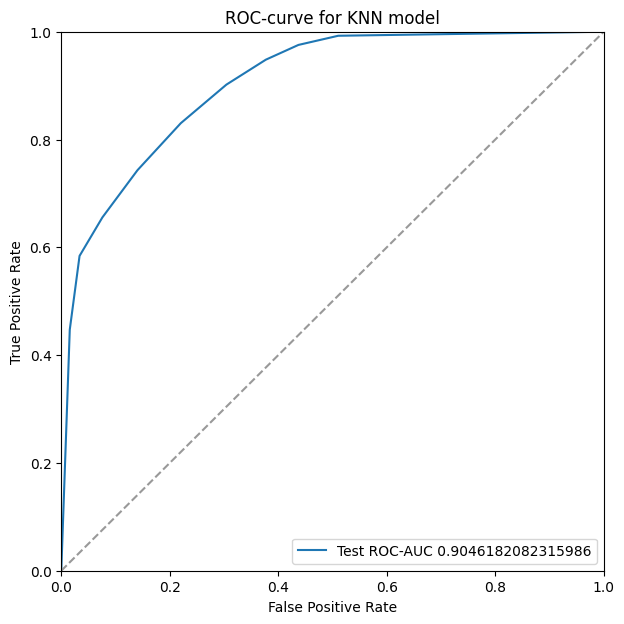

In [ ]:
# Построим ROC-кривую
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, proba_knn)

plt.figure(figsize = (7, 7))
plt.plot(fpr_knn, tpr_knn, label = 'Test ROC-AUC {0}'.format(auc_knn))
plt.plot([0, 1], [0, 1], '--', color = (0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC-curve for KNN model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right');

**Случайный лес**

In [ ]:
# Получим предсказания вероятностей первого класса
proba_rf = best_rf_model.predict_proba(X_test_sc)[:, -1]
# Посчитаем ROC AUC
auc_rf = roc_auc_score(y_test, proba_rf)
print('ROC_AUC = ', auc_rf)

ROC_AUC =  0.9184000958595068


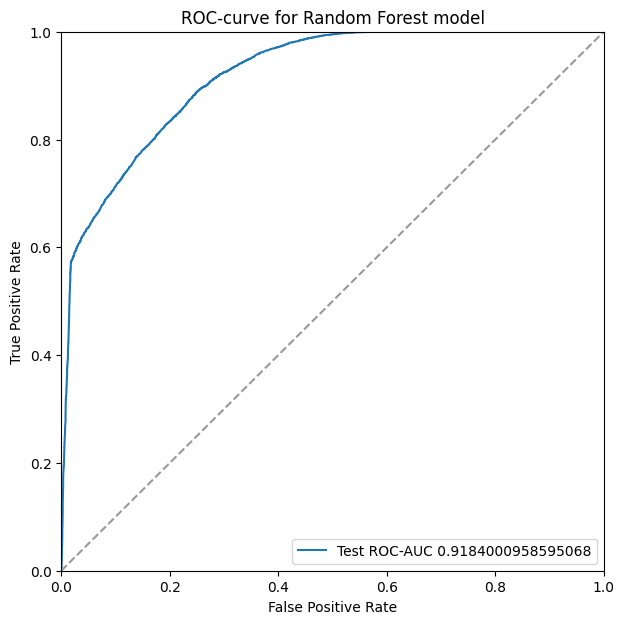

In [ ]:
# Построим ROC-кривую
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, proba_rf)

plt.figure(figsize = (7, 7))
plt.plot(fpr_rf, tpr_rf, label = 'Test ROC-AUC {0}'.format(auc_rf))
plt.plot([0, 1], [0, 1], '--', color = (0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC-curve for Random Forest model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right');

**Градиентный бустинг**

In [ ]:
# Получим предсказания вероятностей первого класса
proba_gb = best_gb_model.predict_proba(X_test_sc)[:, -1]
# Посчитаем ROC AUC
auc_gb = roc_auc_score(y_test, proba_gb)
print('ROC_AUC = ', auc_gb)

ROC_AUC =  0.9179611822088819


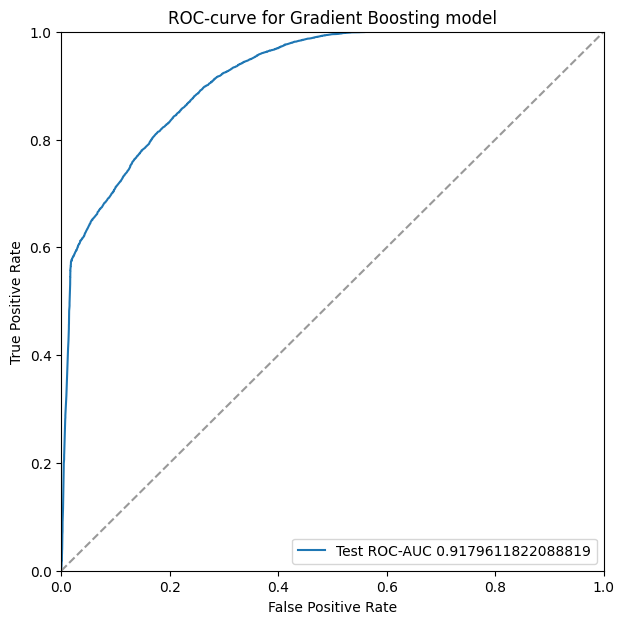

In [ ]:
# Построим ROC-кривую
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, proba_gb)

plt.figure(figsize = (7, 7))
plt.plot(fpr_gb, tpr_gb, label = 'Test ROC-AUC {0}'.format(auc_gb))
plt.plot([0, 1], [0, 1], '--', color = (0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title('ROC-curve for Gradient Boosting model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right');

Повышенная сложность: дополнительно выполните это задание для Байесовской сети.

In [ ]:
# train_data = X_train.copy()
# train_data["Last_Ticket"] = y_train
# test_data = X_test.copy()
# test_data["Last_Ticket"] = y_test
# # Создадим DAG
# edges = [("Days_Before", "Last_Ticket"),
#          ("Distance", "Last_Ticket"),
#          ("Connection", "Last_Ticket"),
#          ("Hours", "Last_Ticket"),
#          ("Distance", "Hours")]
# DAG = bnlearn.make_DAG(edges)
# # Оценим факторы
# bn = bnlearn.parameter_learning.fit(DAG, train_data, methodtype = 'ml')
# np.random.seed(22)
# bn_prob = bnlearn.predict(bn, df = X_test, variables = ['Last_Ticket'], verbose = 0)['p']
# bn_fpr, bn_tpr, bn_thresholds = roc_curve(y_test, bn_prob)
# bn_auc = roc_auc_score(y_test, bn_prob)
# print('ROC_AUC = ', bn_auc)

In [ ]:
# # Построим ROC-кривую для Байесовской сети
# plt.figure(figsize = (7, 7))
# plt.plot(fpr_bn, tpr_bn, label = 'Test ROC-AUC {0}'.format(bn_auc))
# plt.plot([0, 1], [0, 1], '--', color = (0.6, 0.6, 0.6))
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.title('ROC-curve for Bayesian Network model')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend(loc = 'lower right');

6. Постройте матрицу путаницы и предположите цены различных видов прогнозов. Исходя из критерия максимизации прибыли на обучающей выборке подберите оптимальный порог прогнозирования для каждого из методов и сравните прибыли на тестовой выборке при соответствующих порогах. Результат представьте в форме таблицы, в которой должны быть указаны как AUC, так и прибыли (на тестовой выборке). Проинтерпретируйте полученный результат.

In [ ]:
# Для удобства создадим функцию,
# подсчитывающую прибыли при различных порогах
def profits_thresholds(model, features, target,
                       thresholds, prices):
  prob = model.predict_proba(features)[:, 1]    # вероятности
  n_threshold = thresholds.size                 # число порогов
  profits = np.zeros(n_threshold)               # прибыли при разных порогах
  # для каждого возможного порога рассчитываем прибыль
  for i in range(0, n_threshold):
    # получаем прогнозы при соответствующем пороге
    prediction_i = (prob >= thresholds[i]).astype(int)
    # считаем количество прогнозов различного вида
    TN, FP, FN, TP = confusion_matrix(target, prediction_i).ravel()
    # аггрегируем результаты прогнозов
    predictions_i = pd.Series([TP, TN, FP, FN],
                              index = ["TP", "TN", "FP", "FN"])
    # считаем прибыль
    profits[i] = np.sum(prices * predictions_i)
  # Возвращаем результат
  return(profits)

In [ ]:
results = []
prices = np.array([100, -50, 0, -200])
# Оценка моделей
for name, model in zip(['K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting'],
                       [best_knn_model, best_rf_model, best_gb_model]):

    prob_train = model.predict_proba(X_train_sc)[:, -1]
    prob_test = model.predict_proba(X_test_sc)[:, -1]
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, prob_train)

    profits_train = profits_thresholds(model, X_train_sc, y_train, thresholds_train, prices)

    # Оптимальный порог на обучающей выборке
    optimal_threshold = thresholds_train[np.argmax(profits_train)]
    # Содержательный смысл низкого порога - обычно лучше перестраховаться
# и попытаться удержать клиента, даже если он вряд ли уйдет, чем
# столкнуться с риском его потерять, поскольку издержки на удержание
# несопоставимо меньше, чем потери от ухода клиента.

    auc_test = roc_auc_score(y_test, prob_test)

    # Прибыль на тестовой выборке при оптимальном пороге
    profits_test = profits_thresholds(model, X_test_sc, y_test, np.array([optimal_threshold]), prices)
    profit_test = profits_test[0]
    results.append({
        'Model': name,
        'AUC (Test)': auc_test,
        'Optimal Threshold': optimal_threshold,
        'Profit (Test)': profit_test
    })
task6_df = pd.DataFrame(results)
task6_df

,Model,AUC (Test),Optimal Threshold,Profit (Test)
0,K-Nearest Neighbors,0.904618,0.000000,1041300.0
1,Random Forest,0.918400,0.000000,1041300.0
2,Gradient Boosting,0.917961,0.000632,1041300.0


Матрица путаницы для метода ближайших соседей:

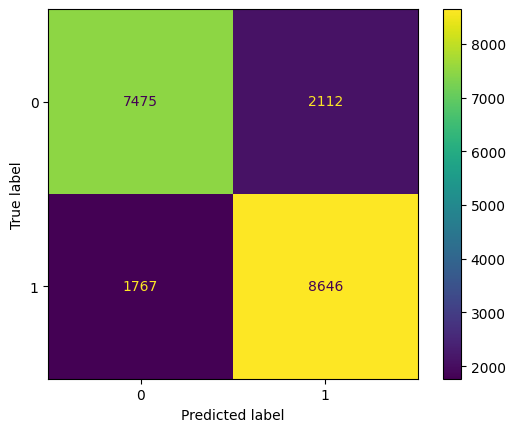

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
y_pred = best_knn_model.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();

Матрица путаницы для случайного леса:

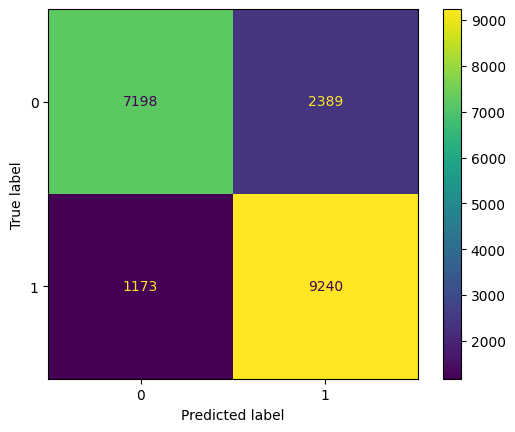

In [ ]:
y_pred = best_rf_model.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();

Матрица путаницы для градиентного бустинга:

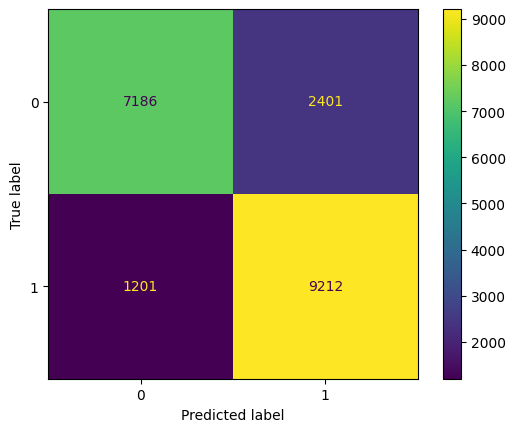

In [ ]:
y_pred = best_gb_model.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot();

**Повышенная сложность:** предложите, содержательно обоснуйте и примените собственную, отличную от линейной функцию прибыли от прогнозов.


Предположим следующую функцию прибыли:
$$100 \times \sqrt{TP} - (50 + \text{marketing cost}) \times FP^{1.5} - (200 + \text{retention cost}) \times \ln{(FN + 1)}$$

In [ ]:
# Придумаем функцию прибыли
# Предположим, что маркетинговые расходы увеличивают затраты на FP и FN
def custom_profit_function(TP, TN, FP, FN, marketing_cost, retention_cost):
    profit = (100 * np.sqrt(TP)) - (50 + marketing_cost) * (FP ** 1.5) - (200 + retention_cost) * np.log(FN + 1)
    return profit
def profits_thresholds(model, features, target, thresholds, prices, marketing_cost, retention_cost):
    prob = model.predict_proba(features)[:, 1]  # Вероятности
    n_threshold = thresholds.size  # Число порогов
    profits = np.zeros(n_threshold)  # Прибыли при разных порогах

    for i in range(n_threshold):
        prediction_i = (prob >= thresholds[i]).astype(int)  # Прогнозы при соответствующем пороге
        TN, FP, FN, TP = confusion_matrix(target, prediction_i).ravel()  # Матрица путаницы
        # Считаем прибыль
        profits[i] = custom_profit_function(TP, TN, FP, FN, marketing_cost, retention_cost)

    return profits

In [ ]:
results_2 = []
marketing_cost = 20  # Пример маркетинговых расходов
retention_cost = 30  # Пример расходов на удержание
prices = np.array([100, -50, 0, -200])

for name, model in zip(['K-Nearest Neighbors', 'Random Forest', 'Gradient Boosting'],
                       [best_knn_model, best_rf_model, best_gb_model]):
  prob_train = model.predict_proba(X_train_sc)[:, -1]
  prob_test = model.predict_proba(X_test_sc)[:, -1]
  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, prob_train)

  profits_train = profits_thresholds(model, X_train_sc, y_train, thresholds_train, prices, marketing_cost, retention_cost)

  # Оптимальный порог на обучающей выборке
  optimal_threshold = thresholds_train[np.argmax(profits_train)]

  # Расчет AUC на тестовой выборке
  auc_test = roc_auc_score(y_test, prob_test)

  # Прибыль на тестовой выборке при оптимальном пороге
  profits_test = profits_thresholds(model, X_test_sc, y_test, np.array([optimal_threshold]), prices, marketing_cost, retention_cost)
  profit_test = profits_test[0]
  results_2.append({
      'Model': name,
      'AUC (Test)': auc_test,
      'Optimal Threshold': optimal_threshold,
      'Profit (Test)': profit_test
  })

# Построение таблицы результатов
task6_df_2 = pd.DataFrame(results_2)
task6_df_2


,Model,AUC (Test),Optimal Threshold,Profit (Test)
0,K-Nearest Neighbors,0.904618,1.000000,-123766.142111
1,Random Forest,0.918400,0.975463,-2623.014668
2,Gradient Boosting,0.917961,0.975562,-3601.490687


7. Опишите предполагаемые связи между переменными в форме ориентированного ациклического графа (DAG). Обучите структуру Байесовской сети на обучающей выборке и сравните точность прогнозов вашего и обученного DAG на тестовой выборке.


In [ ]:
# features_bn = features.copy()
# features_bn['Distance'] = pd.qcut(features_bn['Distance'], q = 4, labels = range(0, 4))
# X_train_bn, X_test_bn = train_test_split(features_bn, test_size = 0.2, random_state = 22)

[bnlearn] >bayes DAG created.
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


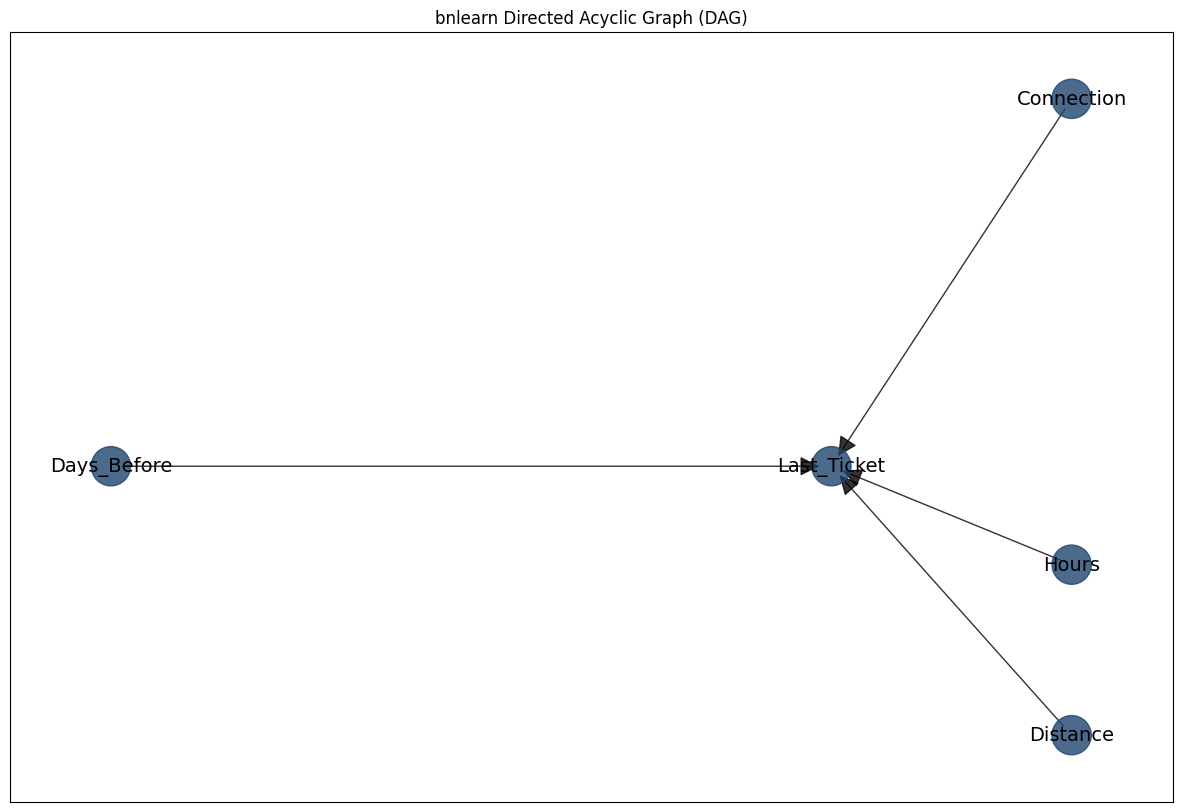

In [162]:
# Создадим DAG
edges = [("Days_Before", "Last_Ticket"),
         ("Distance", "Last_Ticket"),
         ("Connection", "Last_Ticket"),
         ("Hours", "Last_Ticket")]
DAG = bnlearn.make_DAG(edges)

bnlearn.plot(DAG);

In [ ]:

# # Оценим факторы
# bn = bnlearn.parameter_learning.fit(DAG, features_bn, methodtype = 'ml')
# # Оценим параметры модели на обучающей выборке
# bn_train = bnlearn.parameter_learning.fit(DAG, train_data, methodtype = 'ml')
# # Получим прогнозы по тестовой выборке
# predict_bn_test = bnlearn.predict(bn, df = X_test_bn,
#                                   variables = ["Last_Ticket"])
# prediction_bn_test = np.array(predict_bn_test.loc[:, "Last_Ticket"])
# ACC_bn_test = np.mean(y_test == prediction_bn_test)


# # Подберем оптимальную структуру DAG на обучающей выборе
# bn_train_structure = bnlearn.structure_learning.fit(train_data,
#                                                      methodtype = 'hc',
#                                                      scoretype  = 'aic')
# # Сохраним найденный DAG
# DAG2 = bnlearn.make_DAG(bn_train_structure)
# # Оценим модель с подобранным DAG
# bn2_train = bnlearn.parameter_learning.fit(DAG2, train_data,
#                                            methodtype = 'ml')
# # Получим прогнозы по тестовой выборке
# predict_bn2_test = bnlearn.predict(bn2_train, df = X_test_bn,
#                                    variables = ["Last_Ticket"])
# prediction_bn2_test = np.array(predict_bn2_test.loc[:, "Last_Ticket"])
# # Оценим точность прогноза по тестовой выборке
# ACC_bn2_test = np.mean(y_test == prediction_bn2_test)

# # Сравним точность Байесовской сети с
# # исходным и обученным DAG
# print(pd.DataFrame(data    = [ACC_bn_test, ACC_bn2_test],
#                    index   = ['Байесовская сеть с исходным DAG',
#                               'Байесовская сеть с обученным DAG'],
#                    columns = ['ACC-test']))

9. Повышенная сложность: включите в анализ дополнительный метод классификации, не рассматривавшийся в курсе и не представленный в библиотеке
scikit-learn. Опишите данный метод (принцип работы, преимущества и недостатки) и осуществите тюнинг гиперпараметров. Сопоставьте его точность на
тестовой выборке с точностью лучшего из обученных вами ранее методов.

In [ ]:
from catboost import CatBoostClassifier
# Определение модели
catb = CatBoostClassifier(logging_level = 'Silent', random_seed = 22)
# Перебираемые значения гиперпараметров
hyperparameters = {
    'iterations': [100, 400, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8],
}

# Перебор гиперпараметров с помощью кросс-валидации
CV_catb = GridSearchCV(estimator = catb,
                        param_grid = hyperparameters,
                        scoring = "accuracy",
                        cv = 5)
CV_catb.fit(X_train_sc, y_train)
best_catb = CV_catb.best_params_
print(best_catb)

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.01}


In [ ]:
# Cat boost с подобранными гиперпараметрами
best_catb = CatBoostClassifier(iterations = 1000,
                          learning_rate = 0.01,
                          depth = 8 ,
                          logging_level = 'Silent',
                          random_seed= 22)
best_catb.fit(X_train_sc, y_train)
# Оценим точность
ACC_catb_test  = best_catb.score(X_test_sc, y_test)    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
catb_score = cross_val_score(best_catb, X_train_sc, y_train, cv = 5, scoring = 'accuracy').mean()
results_catb = pd.DataFrame({
    'Параметры': ['Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Случайный лес (Лучшая модель)': [rf_score_new, ACC_rf_test_new],
    'CatBoost': [gb_score_new, ACC_gb_test_new]
})
results_catb

,Параметры,Случайный лес (Лучшая модель),CatBoost
0,Кросс-валидационная точность на обучающей выборке,0.822125,0.8221
1,Точность на тестовой выборке,0.821900,0.8199


## Регрессия 🤪


2. Выберите произвольные значения гиперпараметров, а затем оцените и сравните
(между методами) точность прогнозов с помощью RMSE и MAPE:

• на обучающей выборке.

• на тестовой выборке.

• с помощью кросс-валидации (используйте только обучающую выборку).


**Метод ближайших соседей**

In [ ]:
# Нормализуем данные
features_train_sc = scaler.fit_transform(features_train)  # обучающая выборка
features_test_sc  = scaler.fit_transform(features_test)   # тестовая выборка

# Преобразуем в формат pandas DataFrame
features_train_sc = pd.DataFrame(features_train_sc, columns = features_train.columns)
features_test_sc = pd.DataFrame(features_test_sc, columns = features_test.columns)

In [ ]:
from math import sqrt
knn_model_reg = KNeighborsRegressor(n_neighbors = 5)
knn_model_reg.fit(features_train_sc, target_train)

# Прогнозы на обучающей и тестовой выборках
train_pred_knn = knn_model_reg.predict(features_train_sc)
test_pred_knn = knn_model_reg.predict(features_test)

# Оценка точности на обучающей и тестовой выборках
train_rmse_knn = sqrt(mean_squared_error(target_train, train_pred_knn))
train_mape_knn = mean_absolute_percentage_error(target_train, train_pred_knn)
test_rmse_knn = sqrt(mean_squared_error(target_test, test_pred_knn))
test_mape_knn = mean_absolute_percentage_error(target_test, test_pred_knn)
# Посмотрим на результат
itog = pd.DataFrame({
    'Метрика': ['RMSE', 'MAPE'],
    'Обучающая выборка': [train_rmse_knn, train_mape_knn],
    'Тестовая выборка': [test_rmse_knn, test_mape_knn]
})
itog

,Метрика,Обучающая выборка,Тестовая выборка
0,RMSE,20.971492,44.457143
1,MAPE,0.063612,0.151525


In [ ]:
# Оценка точности с помощью кросс-валидации на обучающей выборке
knn_score_rmse = cross_val_score(knn_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
knn_score_mape = cross_val_score(knn_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_mean_absolute_percentage_error').mean()
print("Кросс-валидация - RMSE: {:.3f}, MAPE: {:.3f}%".format(knn_score_rmse, knn_score_mape))

Кросс-валидация - RMSE: -25.703, MAPE: -0.078%


**Случайный лес**

In [ ]:
rf_model_reg = RandomForestRegressor(n_estimators = 100, random_state = 22)
rf_model_reg.fit(features_train_sc, target_train)

# Прогнозы на обучающей и тестовой выборках
train_pred_rf = rf_model_reg.predict(features_train_sc)
test_pred_rf = rf_model_reg.predict(features_test)

# Оценка точности на обучающей и тестовой выборках
train_rmse_rf = sqrt(mean_squared_error(target_train, train_pred_rf))
train_mape_rf = mean_absolute_percentage_error(target_train, train_pred_rf)
test_rmse_rf = sqrt(mean_squared_error(target_test, test_pred_rf))
test_mape_rf = mean_absolute_percentage_error(target_test, test_pred_rf)
# Посмотрим на результат
itog2 = pd.DataFrame({
    'Метрика': ['RMSE', 'MAPE'],
    'Обучающая выборка': [train_rmse_rf, train_mape_rf],
    'Тестовая выборка': [test_rmse_rf, test_mape_rf]
})
itog2

,Метрика,Обучающая выборка,Тестовая выборка
0,RMSE,16.429435,42.103004
1,MAPE,0.047131,0.144374


In [ ]:
# Оценка точности с помощью кросс-валидации на обучающей выборке
rf_score_rmse = cross_val_score(rf_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
rf_score_mape = cross_val_score(rf_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_mean_absolute_percentage_error').mean()
print("Кросс-валидация - RMSE: {:.3f}, MAPE: {:.3f}%".format(rf_score_rmse, rf_score_mape))

Кросс-валидация - RMSE: -27.081, MAPE: -0.082%


**Градиентный бустинг**

In [ ]:
gb_model_reg = GradientBoostingRegressor(n_estimators = 100, random_state = 22)
gb_model_reg.fit(features_train_sc, target_train)

# Прогнозы на обучающей и тестовой выборках
train_pred_gb = gb_model_reg.predict(features_train_sc)
test_pred_gb = gb_model_reg.predict(features_test)

# Оценка точности на обучающей и тестовой выборках
train_rmse_gb = sqrt(mean_squared_error(target_train, train_pred_gb))
train_mape_gb = mean_absolute_percentage_error(target_train, train_pred_gb)
test_rmse_gb = sqrt(mean_squared_error(target_test, test_pred_gb))
test_mape_gb = mean_absolute_percentage_error(target_test, test_pred_gb)
# Посмотрим на результат
itog3 = pd.DataFrame({
    'Метрика': ['RMSE', 'MAPE'],
    'Обучающая выборка': [train_rmse_gb, train_mape_gb],
    'Тестовая выборка': [test_rmse_gb, test_mape_gb]
})
itog3

,Метрика,Обучающая выборка,Тестовая выборка
0,RMSE,23.384894,44.147632
1,MAPE,0.071183,0.156844


In [ ]:
# Оценка точности с помощью кросс-валидации на обучающей выборке
gb_score_rmse = cross_val_score(gb_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
gb_score_mape = cross_val_score(gb_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_mean_absolute_percentage_error').mean()
print("Кросс-валидация - RMSE: {:.3f}, MAPE: {:.3f}%".format(gb_score_rmse, gb_score_mape))

Кросс-валидация - RMSE: -23.486, MAPE: -0.071%


3. Для каждого метода с помощью кросс-валидации на обучающей выборке подберите оптимальные значения гиперпараметров (тюнинг). В качестве критерия
качества используйте RMSE. Результат представьте в форме таблицы, в которой для каждого метода должны быть указаны:

• изначальные и подобранные значения гиперпараметров.

• кросс-валидационное значение RMSE на обучающей выборке с исходными
и подобранными значениями гиперпараметров.

• значение RMSE на тестовой выборке с исходными и подобранными значениями гиперпараметров.


**Метод ближайших соседей**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_neighbors': range(1, 11), 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_knn_reg = GridSearchCV(estimator = knn_model_reg,
                        param_grid = hyperparameters,
                        scoring = "neg_root_mean_squared_error",
                        cv = 5)
CV_knn_reg.fit(X_train_sc, y_train)
best_knn_reg = CV_knn_reg.best_params_
print(best_knn_reg)

{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}


In [ ]:
# Метод ближайших соседей с подобранными гиперпараметрами
best_knn_model_reg = KNeighborsRegressor(n_neighbors = 10, p = 1, weights = 'uniform')
best_knn_model_reg.fit(features_train_sc, target_train)
test_pred_knn_2 = best_knn_model_reg.predict(features_test)
# Оценим точность
RMSE_knn_test_new  = sqrt(mean_squared_error(target_test, test_pred_knn_2))    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
knn_score_new_reg = cross_val_score(best_knn_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
results_knn = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная RMSE на обучающей выборке', 'RMSE на тестовой выборке'],
    'Изначальные значения': [knn_model_reg.get_params(), knn_score_rmse, test_rmse_knn],
    'Подобранные значения': [best_knn_model_reg.get_params(), knn_score_new_reg, RMSE_knn_test_new]
})
pd.set_option('max_colwidth', 200)
results_knn

,Параметры,Изначальные значения,Подобранные значения
0,Гиперпараметры,"{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}","{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}"
1,Кросс-валидационная RMSE на обучающей выборке,-25.703245,-24.61592
2,RMSE на тестовой выборке,44.457143,32.38225


**Случайный лес**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'max_features': ['sqrt', 'log2', None],
                   'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_rf_reg = GridSearchCV(estimator = rf_model_reg,
                        param_grid = hyperparameters,
                        scoring = "neg_root_mean_squared_error",
                        cv = 5)
CV_rf_reg.fit(features_train_sc, target_train)
best_rf_reg = CV_rf_reg.best_params_
print(best_rf_reg)

{'max_depth': 7, 'max_features': None, 'n_estimators': 200, 'random_state': 22}


In [ ]:
# Случайный лес с подобранными гиперпараметрами
best_rf_model_reg = RandomForestRegressor(max_depth = 7, max_features = None, n_estimators = 200, random_state = 22)
best_rf_model_reg.fit(features_train_sc, target_train)
test_pred_rf_2 = best_rf_model_reg.predict(features_test)
# Оценим точность
RMSE_rf_test_new  = sqrt(mean_squared_error(target_test, test_pred_rf_2))    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
rf_score_new_reg = cross_val_score(best_rf_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
results_rf = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная RMSE на обучающей выборке', 'RMSE на тестовой выборке'],
    'Изначальные значения': [rf_model_reg.get_params(), rf_score_rmse, test_rmse_rf],
    'Подобранные значения': [best_rf_model_reg.get_params(), rf_score_new_reg, RMSE_rf_test_new]
})
pd.set_option('max_colwidth', 1000)
results_rf

,Параметры,Изначальные значения,Подобранные значения
0,Гиперпараметры,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 22, 'verbose': 0, 'warm_start': False}","{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 22, 'verbose': 0, 'warm_start': False}"
1,Кросс-валидационная RMSE на обучающей выборке,-27.080712,-23.495984
2,RMSE на тестовой выборке,42.103004,38.595541


**Градиентный бустинг**

In [ ]:
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'max_features': ['sqrt', 'log2', None],
                   'random_state': [22]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_gb_reg = GridSearchCV(estimator = gb_model_reg,
                        param_grid = hyperparameters,
                        scoring = "neg_root_mean_squared_error",
                        cv = 5)
CV_gb_reg.fit(features_train_sc, target_train)
best_gb_reg = CV_gb_reg.best_params_
print(best_gb_reg)

{'max_depth': 3, 'max_features': None, 'n_estimators': 100, 'random_state': 22}


In [ ]:
# Градиентный бустинг с подобранными гиперпараметрами
best_gb_model_reg = GradientBoostingRegressor(max_depth = 3, max_features = None, n_estimators = 100, random_state = 22)
best_gb_model_reg.fit(features_train_sc, target_train)
test_pred_gb_2 = best_gb_model_reg.predict(features_test)
# Оценим точность
RMSE_gb_test_new  = sqrt(mean_squared_error(target_test, test_pred_gb_2))    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
gb_score_new_reg = cross_val_score(best_gb_model_reg, features_train_sc, target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
results_gb = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная RMSE на обучающей выборке', 'RMSE на тестовой выборке'],
    'Изначальные значения': [gb_model_reg.get_params(), gb_score_rmse, test_rmse_gb],
    'Подобранные значения': [best_gb_model_reg.get_params(), gb_score_new_reg, RMSE_gb_test_new]
})
pd.set_option('max_colwidth', 1000)
results_gb

,Параметры,Изначальные значения,Подобранные значения
0,Гиперпараметры,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 22, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}","{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 22, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}"
1,Кросс-валидационная RMSE на обучающей выборке,-23.486032,-23.486032
2,RMSE на тестовой выборке,44.147632,44.147632


**Повышенная сложность:** подберите на обучающей выборке оптимальные
значения гиперпараметров градиентного бустинга ориентируясь на значение
OOB (out-of-bag) ошибки. Сопоставьте гиперпараметры и точность на тестовой выборке для градиентного бустинга в зависимости от того, используется
кросс-валидация или OOB ошибка.

In [ ]:
gb_model_oob = GradientBoostingRegressor(random_state = 22)
from sklearn.metrics import make_scorer
# Создадим альтернативный критерий
def calculate_oob_error(model, X_data, y_data):
    model.oob_score = True
    model.fit(X_data, y_data)
    oob_error = 1 - model.oob_score_
    return oob_error

oob_scorer = make_scorer(calculate_oob_error, greater_is_better = False)
# Перебираемые значения гиперпараметров
hyperparameters = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'max_features': ['sqrt', 'log2', None]}

# Перебор гиперпараметров с помощью кросс-валидации
CV_gb_oob = GridSearchCV(estimator = gb_model_oob,
                        param_grid = hyperparameters,
                        scoring = oob_scorer,
                        cv = 5)
CV_gb_oob.fit(features_train_sc, target_train)
best_gb_oob = CV_gb_oob.best_params_
print(best_gb_oob)

{'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 50}


In [ ]:
# Градиентный бустинг с подобранными гиперпараметрами
best_gb_oob = GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)
best_gb_oob.fit(features_train_sc, target_train)
test_pred_gb_3 = best_gb_oob.predict(features_test)
# Оценим точность
RMSE_gb_oob  = sqrt(mean_squared_error(target_test, test_pred_gb_3))    # тестовая выборка
# Оценка точности с помощью кросс-валидации на обучающей выборке
gb_score__oob = cross_val_score(best_gb_oob, features_train_sc, target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean()
results_gb = pd.DataFrame({
    'Параметры': ['Гиперпараметры', 'Кросс-валидационная точность на обучающей выборке', 'Точность на тестовой выборке'],
    'Кросс-валидация': [best_gb_model_reg.get_params(), gb_score_new_reg, RMSE_gb_test_new],
    'OOB ошибки': [best_gb_oob.get_params(), gb_score__oob, RMSE_gb_oob],
})
pd.set_option('max_colwidth', 1000)
results_gb

,Параметры,Кросс-валидация,OOB ошибки
0,Гиперпараметры,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 22, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}","{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_iter_no_change': None, 'random_state': 22, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}"
1,Кросс-валидационная точность на обучающей выборке,-23.486032,-23.559869
2,Точность на тестовой выборке,44.147632,32.3737


5. **Повышенная сложность:** включите в анализ дополнительный метод регрессии, не рассматривавшийся в курсе и не представленный в библиотеке scikitlearn. Опишите данный метод (принцип работы, преимущества и недостатки)
и осуществите тюнинг гиперпараметров. Сопоставьте его точность на тестовой
выборке с точностью лучшего из обученных вами ранее методов.


In [ ]:
from catboost import CatBoostRegressor
# Определение модели
catb_reg = CatBoostRegressor(random_seed = 22)
# Перебираемые значения гиперпараметров
hyperparameters = {
    'iterations': [100, 400, 1000],
    'learning_rate': [0.1, 0.01, 0.001],
    'depth': [4, 6, 8],
    'logging_level':["Silent"]
}

# Перебор гиперпараметров с помощью кросс-валидации
CV_catb_reg = GridSearchCV(estimator = catb_reg,
                        param_grid = hyperparameters,
                        scoring = "neg_root_mean_squared_error",
                        cv = 5)
CV_catb_reg.fit(features_train_sc, target_train)
best_catb_reg = CV_catb_reg.best_params_
print(best_catb_reg)

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.01, 'logging_level': 'Silent'}


In [ ]:
# Cat boost с подобранными гиперпараметрами
best_catb = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.01,
                          depth = 8,
                          logging_level = 'Silent',
                          random_seed= 22)
best_catb.fit(features_train_sc, target_train)
test_pred_catb = best_catb.predict(features_test)
# Оценим точность
RMSE_catb  = sqrt(mean_squared_error(target_test, test_pred_catb))
results_catb_reg = pd.DataFrame({
    'Параметры': ['RMSE на тестовой выборке'],
    'GB OOB (Лучшая модель)': [RMSE_gb_oob],
    'CatBoost': [RMSE_catb]
})
results_catb_reg

,Параметры,GB OOB (Лучшая модель),CatBoost
0,RMSE на тестовой выборке,32.3737,33.983326


## Эффекты воздействия 🤪


2. Используя симулированные вами, но недоступные в реальных данных потенциальные исходы (гипотетические значения), получите оценки среднего эффекта
воздействия, условных средних эффектов воздействия и локального среднего
эффекта воздействия. Результаты представьте в форме таблицы.

**Примечание:** для получения очень точных оценок эффектов воздействия с
помощью потенциальных исходов (гипотетических переменных) можно сперва
симулировать очень большого число наблюдений, например, несколько миллионов. Затем, для ускорения вычислений, для оценивания эффектов воздействия
с помощью наблюдемых значений можно использовать часть выборки, например, десять тысяч наблюдений.

**Оценивание эффектов воздействия с помощью потенциальных исходов** 🐱

Эффект воздействия:

$$\text{TE}_{i} = \text{Ticket_Price}_{1i} - \text{Ticket_Price}_{0i}$$

In [ ]:
# Настоящие эффекты воздействия (не наблюдаются в данных)
TE = ticket_price_1 - ticket_price_0
print(TE[0:10])

[39.39728716 71.1064289  37.98858075 29.0063037  44.89107144 41.93234692
 48.28493108 34.41047668 52.43698966 43.9808042 ]


Средний эффект воздействия:

$$\text{ATE} = \text{E}\left(\text{Ticket_Price}_{1i} - \text{Ticket_Price}_{0i}\right)$$

Если бы у нас были данные о $\text{Ticket_Price}_{1i}$ и $\text{Ticket_Price}_{0i}$, то мы могли бы очень точно оценить $\text{ATE}$ как:

$$\widehat{\text{ATE}} = \frac{1}{n}\sum\limits_{i=1}^{n}\text{Ticket_Price}_{1i} - \text{Ticket_Price}_{0i}$$

In [ ]:
# Точное приближение среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
ATE = np.mean(TE)
print(ATE)

43.51382217878924


Локальный средний эффект воздействия:

$$\text{LATE} = \text{E}(\text{Ticket_Price}_{1i} - \text{Ticket_Price}_{0i} | \text{Last_Ticket}_{1i} > \text{Last_Ticket}_{0i})$$

In [ ]:
# Точное приближение локального среднего эффекта воздействия, то есть
# с помощью оценки, недоступной с помощью реальных данных
LATE = np.mean(TE[ind_type == 'Occupied at rush hour'])
print(LATE)

43.460487471938414


Условный средний эффект воздействия:

$$\text{CATE}_{i} = \text{E}\left(\text{Ticket_Price}_{1i}|X_{i}\right) - \text{E}\left(\text{Ticket_Price}_{0i}|X_{i}\right) = g_{1}(X_{i}) - g_{0}(X_{i})$$

In [ ]:
# Значения локальных средних эффектов воздействия
CATE = g1 - g0
print(CATE[0:10])

[47.03827834 44.133095   43.6965091  39.62167886 43.50471051 43.60461699
 44.79672992 41.50145668 43.37956764 38.11915699]


Представим результаты в виде таблицы:

In [ ]:
results_effects =  pd.DataFrame({
    'Эффект': ['ATE', 'LATE', 'CATE'],
    'Значение': [ATE, LATE, CATE.mean()]
})
results_effects

,Эффект,Значение
0,ATE,43.513822
1,LATE,43.460487
2,CATE,43.489507


3. Оцените средний эффект воздействия как разницу в средних по выборкам тех,
кто получил и не получил воздействие. Опишите недостатки соответствующего
подхода с учетом специфики рассматриваемой вами экономической проблемы.

**Примечание:** в этом пункте и далее, если не сказано иное, используются лишь
наблюдаемые значения целевой переменной.

**Оценивание ATE как разницы в средних** 🐱

Допущение о независимости:

$$\text{E}(\text{Ticket_Price}_{1i}|\text{Last_Ticket}_{i}=1) = \text{E}(\text{Ticket_Price}_{1i})\qquad \text{E}(\text{Ticket_Price}_{0i}|\text{Last_Ticket}_{i}=0) = \text{E}(\text{Ticket_Price}_{0i})$$

Попробуем оценить ATE наивным способом, опирающимся на допущение о независимости, которое не соблюдается в данном случае, поскольку $\text{Distance}_{i}$, $\text{Days_Before}_{i}$ и $\text{Connection}_{i}$ одновременно связаны и с количесвтом свободных мест $\text{Last_Ticket}_{i}$, и с ценой авиабилета $\text{Ticket_Price}_{i}$.

Наивный подход предполагает оценивание $\text{ATE}$ как средней разницы в ценах авиабилетов на самолёты с количеством свободных мест меньше 20 и больше.

$$\widehat{\text{ATE}}_{\text{naive}} = \frac{1}{n_{1}}\sum\limits_{i:\text{Last_Ticket}_{i}=1}\text{Ticket_Price}_{1i} - \frac{1}{n_{0}}\sum\limits_{i:\text{Last_Ticket}_{i}=0}\text{Ticket_Price}_{0i}$$
Где $n_{1}$ и $n_{0}$ - число самолётов с количеством свободных мест меньше 20 и больше, соответственно.

In [ ]:
# Наивная оценка как разница в выборочных средних
ATE_naive = np.mean(Ticket_Price[Last_Ticket == 1]) - np.mean(Ticket_Price[Last_Ticket == 0])

# Сравнение точного приближения и наивной оценки
# когда у его родителей нет высшего образования и когда оно у них есть
print(pd.DataFrame(data    = [ATE, ATE_naive],
                   index   = ['Точная оценка с помощью потенциальных исходов',
                              'Наивная оценка с помощью наблюдаемых исходов'],
                   columns = ['ATE']))

                                                     ATE
Точная оценка с помощью потенциальных исходов  43.513822
Наивная оценка с помощью наблюдаемых исходов   59.834971


4. Используя оценки, полученные лучшими из обученных ранее классификационных и регрессионных моделей, оцените средний эффект воздействия с помощью:

• метода наименьших квадратов.

• условных математических ожиданий.

• взвешивания на обратные вероятности (в случае возникновения ошибок убедитесь в отсутствии оценок вероятностей, равных 0 или 1 и при необходимости измените метод оценивания).

• метода, обладающего двойной устойчивостью.

• двойного машинного обучения.

Сравните результаты и назовите ключевую предпосылку этих методов. Содержательно обсудите причины, по которым она может соблюдаться или нарушаться в вашем случае. Приведите содержательную экономическую интерпретацию оценки среднего эффекта воздействия.

**Лучшая модель классификации:** случайный лес с подобранными гиперпараметрами RandomForestClassifier(max_depth = 7, max_features = 'sqrt', n_estimators = 200, random_state = 22)

**Лучшая модель регрессии:** градиентный бустинг и спользованием OOB ошибки GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)

**Метод наименьших квадратов**

Ослабим допущение о независимости до допущения об условной независимости:

$$\text{E}(\text{Ticket_Price}_{1i}|\text{Last_Ticket}_{i}=1,X_{i}) = \text{E}(\text{Ticket_Price}_{1i}|X_{i})\qquad \text{E}(\text{Ticket_Price}_{0i}|\text{Last_Ticket}_{i}=0,X_{i}) = \text{E}(\text{Ticket_Price}_{0i}|X_{i})$$

Попробуем оценить $\text{ATE}$, рассмотрев среднюю разницу в оценках цен на авиабилеты, полученных с помощью МНК отдельно сперва для самолётов с количеством свободных мест менее 20, а потом для самолётов с количеством свободных мест более 20.

$$\widehat{\text{ATE}}_{\text{LS}} = \frac{1}{n}\sum\limits_{i=1}^{n} \underbrace{\hat{\text{E}}\left(\text{Ticket_Price}_{1i}|X_{i}\right) - \hat{\text{E}}\left(\text{Ticket_Price}_{0i}|X_{i}\right)}_{\widehat{\text{CATE}}_{i}}$$

Где:


*   $\hat{\text{E}}\left(\text{Ticket_Price}_{1i}|X_{i}\right)$ - оценка, полученная с использованием МНК оценок регрессионных коэффициентов $\beta$, полученных по выборке из самолётов с количеством свободных мест менее 20 $\text{Last_Ticket}_{i} = 1$.
*   $\hat{\text{E}}\left(\text{Ticket_Price}_{0i}|X_{i}\right)$ - оценка, полученная с использованием МНК оценок регрессионных коэффициентов $\beta$, полученных по выборке из  самолётов с количеством свободных мест более 20 $\text{Last_Ticket}_{i} = 0$.



In [ ]:
# Оценим средний эффект воздействия с помощью МНК

# МНК оценивание уравнения цен на авиабилеты для
# самолётов с количеством свободных мест более 20
y0 = df.loc[Last_Ticket == 0, ['Ticket_Price']]
x0 = df.loc[Last_Ticket == 0, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]
x0 = sm.add_constant(x0)
ols0 = sm.OLS(y0, x0).fit()

# МНК оценивание уравнения цен на авиабилеты для
# самолётов с количеством свободных мест менее 20
y1 = df.loc[Last_Ticket == 1, ['Ticket_Price']]
x1 = df.loc[Last_Ticket == 1, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]
x1 = sm.add_constant(x1)
ols1 = sm.OLS(y1, x1).fit()

# Оценим цены на авиабилеты при количестве свободных мест больше и меньше 20
# с помощью полученных МНК оценок
x = df.loc[:, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]
x = sm.add_constant(x)
  # МНК оценка E(Ticket_Price0 | X) для всех индивидов
Ticket_Price0_ols = ols0.predict(x)
  # МНК оценка E(Ticket_Price1 | X) для всех индивидов
Ticket_Price1_ols = ols1.predict(x)

# Оценки CATE
CATE_ols = np.array(Ticket_Price1_ols - Ticket_Price0_ols)

# Оценка ATE как средняя разница в прогнозах МНК оценок
ATE_ols = np.mean(CATE_ols)

In [ ]:
# Сравним результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ols],
                   index   = ['ATE', 'ATE naive', "ATE ols"],
                   columns = ['Оценка']))

              Оценка
ATE        43.513822
ATE naive  59.834971
ATE ols    54.627254


**Условные математические ожидания**

Будем оценивать ATE с помощью S-learner. Выбираем в качестве метода машинного обучения метод ближайших соседей с подобранными гиперпараметрами, поскольку он показал лучшие результаты RMSE.

Оценка $\text{S-learner}$ метода будет иметь такой вид:

$$\widehat{\text{CATE}}^{\text{S-learner}}_{i} = \frac{1}{n}\sum\limits_{i=1}^{n} \hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i},\text{Last_Ticket}_{i}=1\right) - \hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i},\text{Last_Ticket}_{i}=0\right)$$

Однако, методы оценивания самих условных математических ожиданий различаются:

*   $\hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i},\text{Last_Ticket}_{i}=1\right)$ - оценка, полученная с использованием метода машинного обучения по всей выборке.
*   $\hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i},\text{Last_Ticket}_{i}=0\right)$ - оценка, полученная с использованием метода машинного обучения по всей выборке.

In [ ]:
# Оценивание ATE и CATE с помощью S-learner

# Подготовим данные
y = df.loc[:, ['Ticket_Price']]
x = df.loc[:, df.columns.drop(['Ticket_Price', 'Hours'])]

# Подготовка модели: единая для тех, у кого менее
# 20 свободных мест и у кого более
gb2 = GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)
gb2.fit(x, y)

# Оценки E(Ticket_Price | X, Last_Ticket = 0) для всех самолётов,
# в том числе для тех, у кого (Last_Ticket = 1).
x0 = deepcopy(x)
x0["Last_Ticket"] = 0
Ticket_Price0_gb2 = gb2.predict(x0)

# Оценки E(Ticket_Price | X, Last_Ticket = 1) для всех самолётов,
# в том числе для тех, у кого (Last_Ticket = 0).
x1 = deepcopy(x)
x1["Last_Ticket"] = 1
Ticket_Price1_gb2 = gb2.predict(x1)

# Оценки CATE
CATE_S = Ticket_Price1_gb2 - Ticket_Price0_gb2

# Оценка ATE
ATE_S = np.mean(CATE_S)

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ols, ATE_S],
                   index   = ['ATE', 'ATE naive', 'ATE ols', 'ATE S-learner'],
                   columns = ['Оценка']))

                  Оценка
ATE            43.513822
ATE naive      59.834971
ATE ols        54.627254
ATE S-learner  58.001282


**Взвешивание на обратные вероятности**

Оценка, получаемая с помощью взвешивания на обратные вероятности $\text{IPW}$, имеет вид:

$$\widehat{\text{ATE}}^{\text{IPW}} = \frac{1}{n}\sum\limits_{i=1}^{n}\frac{\text{Last_Ticket}_{i}\times\text{Ticket_Price}_{i}}{\hat{P}\left(\text{Last_Ticket}_{i}=1|X_{i}\right)} - \frac{\left(1 - \text{Last_Ticket}_{i}\right)\times\text{Ticket_Price}_{i}}{1 - \hat{P}\left(\text{Last_Ticket}_{i}=1|X_{i}\right)}$$

Где условные вероятности $\hat{P}\left(\text{Last_Ticket}_{i}=1|X_{i}\right)$ оценивается с помощью методов классификации. В нашем случае с помощью случайного леса с подобранными гиперпараметрами, поскольку данная модель лучшая с точки зрения точности.

In [ ]:
# Оценивание с помощью обратного взвешивания на вероятности IPW

# Подготовим данные
target = df.loc[:, ['Last_Ticket']]
features = df.loc[:, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]

# Подготовим метод машинного обучения
rf = RandomForestClassifier(max_depth = 7, max_features = 'sqrt', n_estimators = 200, random_state = 22)
rf.fit(features, target)

# Оценим условные вероятности P(Last_Ticket = 1 | X)
prob_rf = rf.predict_proba(features)[:, 1]

# Оценим псевдоисходы
Ticket_Price_pseudo = (Ticket_Price * Last_Ticket) / prob_rf - (Ticket_Price * (1 - Last_Ticket)) / (1 - prob_rf)

# Оценим ATE
ATE_IPW = np.mean(Ticket_Price_pseudo)

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ols, ATE_S, ATE_IPW],
                   index   = ['ATE', 'ATE naive', 'ATE ols', 'ATE S-learner', 'ATE_IPW'],
                   columns = ['Оценка']))

                  Оценка
ATE            43.513822
ATE naive      59.834971
ATE ols        54.627254
ATE S-learner  58.001282
ATE_IPW        44.344613


**Метод, обладающий двойной устойчивостью.**

Методом с двойной устойчивостью средний эффект воздействия оценивается как:

$$\widehat{\text{ATE}}^{\text{DR}} = \frac{1}{n}\sum\limits_{i=1}^{n}\hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i}, T_{i}=1\right) - \hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i}, T_{i}=0\right) + \frac{\text{Last_Ticket}_{i}\times\left(\text{Ticket_Price}_{i}-\hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i}, T_{i}=1\right)\right)}{\hat{P}(\text{Last_Ticket}_{i}=1|X_{i})} - \frac{\left(1-\text{Last_Ticket}_{i}\right)\times\left(\text{Ticket_Price}_{i}-\hat{\text{E}}\left(\text{Ticket_Price}_{i}|X_{i}, T_{i}=0\right)\right)}{1 - \hat{P}(\text{Last_Ticket}_{i}=1|X_{i})}$$

In [ ]:
# поскольку наблюдений достаточно много, и возникают проблему с ОЗУ,
#  сократим количество наблюдений в необходимых переменных до 10 000
Ticket_Price1_gb2_subset = Ticket_Price1_gb2[:10000]
Ticket_Price0_gb2_subset = Ticket_Price0_gb2[:10000]
Last_Ticket_subset = Last_Ticket[:10000]
Ticket_Price_subset = Ticket_Price[:10000]
prob_rf_subset = prob_rf[:10000]

In [ ]:
# Оценим ATE с помощью DR метода с двойной устойчивостью
ATE_DR = np.mean((Ticket_Price1_gb2_subset - Ticket_Price0_gb2_subset) + \
                 Last_Ticket_subset * (Ticket_Price_subset - Ticket_Price1_gb2_subset) / prob_rf_subset - \
                 (1 - Last_Ticket_subset) * (Ticket_Price_subset - Ticket_Price0_gb2_subset) / (1 - prob_rf_subset))

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ols, ATE_S, ATE_IPW, ATE_DR],
                   index   = ['ATE', 'ATE naive', 'ATE ols', 'ATE S-learner', 'ATE_IPW', 'ATE_DR'],
                   columns = ['Оценка']))

                  Оценка
ATE            43.513822
ATE naive      59.834971
ATE ols        54.627254
ATE S-learner  58.001282
ATE_IPW        44.344613
ATE_DR         59.974247


**Двойное машинное обучение**

In [ ]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'Ticket_Price',
                            d_cols = 'Last_Ticket',
                            x_cols = ['Days_Before', 'Distance', 'Connection'])

# Метод оценивания E(Y | X, T)
g_Y = GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)

# Метод оценивания E(T | X)
g_T =  RandomForestClassifier(max_depth = 7, max_features = 'sqrt', n_estimators = 200, random_state = 22)

# Подготовка объекта
dml_standard = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y, ml_m = g_T,
                               n_rep = 1,
                               n_folds = 5)

# Оценим параметры
dml_standard.fit()

# Сохраним оценку
ATE_dml_standard = dml_standard.coef[0]

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ols, ATE_S, ATE_IPW, ATE_DR, ATE_dml_standard],
                   index   = ['ATE', 'ATE naive', 'ATE ols', 'ATE S-learner', 'ATE_IPW', 'ATE_DR', 'ATE_dml_standard'],
                   columns = ['Оценка']))

                     Оценка
ATE               43.513822
ATE naive         59.834971
ATE ols           54.627254
ATE S-learner     58.001282
ATE_IPW           44.344613
ATE_DR            59.974247
ATE_dml_standard  61.500218


**Повышенная сложность:** включите дополнительный метод, не рассматривавшийся в курсе, и опишите его принцип работы, а также преимущества и
недостатки по сравнению с другими методами.


Давайте оценим ATE с помощью Matching Estimator в Causal Model. 🙆‍♂️

Метод Matching используется для оценки среднего эффекта воздействия (ATE) путём сопоставления наблюдений из группы воздействия с наблюдениями из контрольной группы на основе схожих характеристик (ковариат).

Первым шагом является оценка propensity score - вероятность получения воздействия для $i-го$ наблюдения, вычисленная с использованием логистической регрессии или другого метода - для каждого наблюдения:

$$\widehat{\text{p}}(\text{X}_{i}) = \text{P}\left(\text{Last_Ticket}_{i} = 1|\text{Days_Before}_{i}, \text{Distance}_{i}, \text{Connection}_{i}, \text{Hours}_{i}\right)$$

Затем Для каждого наблюдения $i$ из группы воздействия $(\text{Last_Ticket}_{i} = 1)$ находим наблюдение $j$ из контрольной группы $(\text{Last_Ticket}_{j} = 0)$, которое имеет наиболее схожий propensity score:

$$j = \text{argmin}_{\text{j}: \text{Last_Ticket}_{j} = 0} = |\widehat{\text{p}}(\text{X}_{i}) - \widehat{\text{p}}(\text{X}_{j})|$$

Затем для каждой пары $(i,j)$ оцениваем разность в целевой переменной:

$$\Delta \text{Ticket_Price}_{\text{ij}} = \text{Ticket_Price}_{\text{i}} - \text{Ticket_Price}_{\text{j}} $$

Найдем средний эффект воздействия (ATE), который оценивается как среднее значение разностей в целевой переменной для всех пар:

$$\text{ATE} = \frac{1}{n}\sum_{(i, j)}(\text{Ticket_Price}_{i} - \text{Ticket_Price}_{j})$$

In [ ]:
# поскольку наблюдений достаточно много, и возникают проблемы с ОЗУ,
#  сократим количество наблюдений в необходимых переменных до 10 000
df_subset = df.head(10000)
from causalinference import CausalModel
Y =  df_subset['Ticket_Price'].values
D = df_subset['Last_Ticket'].values
X = df_subset[['Days_Before', 'Distance', 'Connection']].values
cm = CausalModel(Y, D, X)
cm.est_via_matching()
ATE_matching = cm.estimates['matching']['ate']

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, ATE_naive, ATE_ols, ATE_S, ATE_IPW, ATE_DR, ATE_dml_standard, ATE_matching],
                   index   = ['ATE', 'ATE naive', 'ATE ols', 'ATE S-learner', 'ATE_IPW', 'ATE_DR', 'ATE_dml_standard', 'ATE_matching'],
                   columns = ['Оценка']))

                     Оценка
ATE               43.513822
ATE naive         59.834971
ATE ols           54.627254
ATE S-learner     58.001282
ATE_IPW           44.344613
ATE_DR            59.974247
ATE_dml_standard  61.500218
ATE_matching      62.258918


5. Оцените локальный условный эффект воздействия с помощью:

• двойного машинного обучения без инструментальной переменной.

• двойного машинного обучения с инструментальной переменной.


Представим, что переменная $\text{Population}_{i}$ отсутствует в данных, из-за чего возникает эндогенность, поскольку эта переменная влияет и на цену авиабилета $\text{Ticket_Price}_{i}$, и на количество свободных мест $\text{Last_Ticket}_{i}$.

Напомним, что при наличии эндогенности с помощью инструментальных переменных мы можем оценить лишь $\text{LATE}$, а не $\text{ATE}$.

Попробуем сперва воспользоваться **ДМО** методом **без инструментальных переменных**, чтобы продемонстрировать проблемы, возникающие при игнорировании эндогенности.

In [ ]:
# Данные в формате, необходимом для применения DML
dml_standard2_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'Ticket_Price',
                             d_cols = 'Last_Ticket',
                             x_cols = ['Days_Before', 'Distance', 'Connection'])

# Подготовка объекта
dml_standard2 = dml.DoubleMLIRM(obj_dml_data = dml_standard2_data,
                                ml_g = g_Y, ml_m = g_T,
                                n_rep = 1,
                                n_folds = 5)

# Оценим параметры
dml_standard2.fit()

# Посмотрим на результат
print(dml_standard2)

# Сохраним оценку
LATE_dml_standard2 = dml_standard2.coef[0]

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: Ticket_Price
Treatment variable(s): ['Last_Ticket']
Covariates: ['Days_Before', 'Distance', 'Connection']
Instrument variable(s): None
No. Observations: 100000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(max_features='sqrt', n_estimators=50, random_state=22)
Learner ml_m: RandomForestClassifier(max_depth=7, n_estimators=200, random_state=22)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[13.81456259]]
Learner ml_g1 RMSE: [[12.65537147]]
Learner ml_m RMSE: [[0.34790467]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
                 coef   std err           t  P>|t|      2.5 %     97.5 %
Last_Ticket  61.47864  0.128965

Теперь воспользуемся **ДМО** методом оценивания $\text{LATE}$ **с помощью инструментальных переменных**.

In [ ]:
# Данные в формате, необходимом для применения DML
dml_iv_data = dml.DoubleMLData(data = df,
                               y_col = 'Ticket_Price',
                               d_cols = 'Last_Ticket',
                               z_cols = 'Hours',
                               x_cols = ['Days_Before', 'Distance', 'Connection'])

# Метод оценивания E(Z | X)
g_Z = RandomForestClassifier(max_depth = 7, max_features = 'sqrt', n_estimators = 200, random_state = 22)

# Подготовка объекта
dml_iv = dml.DoubleMLIIVM(obj_dml_data = dml_iv_data,
                          ml_g = g_Y, ml_m = g_Z, ml_r = g_T,
                          n_rep = 1,
                          n_folds = 5)

# Оценим параметры
dml_iv.fit()

# Посмотрим на результат
print(dml_iv)

# Сохраним оценку
LATE_dml_iv = dml_iv.coef[0]

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: Ticket_Price
Treatment variable(s): ['Last_Ticket']
Covariates: ['Days_Before', 'Distance', 'Connection']
Instrument variable(s): ['Hours']
No. Observations: 100000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(max_features='sqrt', n_estimators=50, random_state=22)
Learner ml_m: RandomForestClassifier(max_depth=7, n_estimators=200, random_state=22)
Learner ml_r: RandomForestClassifier(max_depth=7, n_estimators=200, random_state=22)
Out-of-sample Performance:
Learner ml_g0 RMSE: [[24.42986752]]
Learner ml_g1 RMSE: [[21.91458103]]
Learner ml_m RMSE: [[0.25717428]]
Learner ml_r0 RMSE: [[0.37783278]]
Learner ml_r1 RMSE: [[0.28784657]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, LATE, LATE_dml_standard2, LATE_dml_iv],
                   index   = ['ATE', 'LATE', 'LATE dml standard2', 'LATE dml iv'],
                   columns = ['Оценка']))

                       Оценка
ATE                 43.513822
LATE                43.460487
LATE dml standard2  61.478640
LATE dml iv         42.933342


**Повышенная сложность:** воспользуйтесь также параметрической моделью,
например, с помощью пакета switchSelection. Обсудите преимущества и недостатки такого подхода по сравнению с двойным машинным обучением.

In [ ]:
from statsmodels.sandbox.regression.gmm import IV2SLS
# Подготовка данных
X = df[['Days_Before', 'Distance', 'Connection', 'Last_Ticket']]
y = df['Ticket_Price']
z = df['Hours']
X = sm.add_constant(X)

# Определение и оценка модели
model_2sls = IV2SLS(y, X, z).fit()

# Печать результатов
print(model_2sls.summary())

                          IV2SLS Regression Results                           
Dep. Variable:           Ticket_Price   R-squared:                   -1666.632
Model:                         IV2SLS   Adj. R-squared:              -1666.699
Method:                     Two Stage   F-statistic:                 1.210e-10
                        Least Squares   Prob (F-statistic):               1.00
Date:                Sun, 09 Jun 2024                                         
Time:                        16:13:36                                         
No. Observations:              100000                                         
Df Residuals:                   99995                                         
Df Model:                           4                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         269.3759   1.45e+09   1.86e-07      

In [ ]:
# Оценка LATE
LATE_iv_2sls = model_2sls.params['Last_Ticket']
LATE_iv_2sls

-1327.2131147540983

In [ ]:
# Сопоставим результаты
print(pd.DataFrame(data    = [ATE, LATE, LATE_dml_standard2, LATE_dml_iv, LATE_iv_2sls],
                   index   = ['ATE', 'LATE', 'LATE dml standard2', 'LATE dml iv', 'LATE IV 2SLS'],
                   columns = ['Оценка']))

                         Оценка
ATE                   43.513822
LATE                  43.460487
LATE dml standard2    61.478640
LATE dml iv           42.933342
LATE IV 2SLS       -1327.213115


6. Оцените условные средние эффекты воздействия с помощью:

• метода наименьших квадратов.

• S-learner.

• T-learner.

• метода трансформации классов.

• X-learner.


**Метод наименьших квадратов.**

In [ ]:
# см. пункт с методом наименьших квадратов для ATE
CATE_ols

array([55.67315433, 55.76960676, 55.70138055, ..., 53.0898094 ,
       56.27235539, 56.21180099])

**S-learner.**

In [ ]:
# см. пункт с S-learner для ATE
CATE_S

array([69.60573405, 53.17848578, 54.26332667, ..., 55.67390937,
       67.5853764 , 54.78771297])

**T-learner.**

Условные эффекты воздействия $\text{CATE}_{i}$ определяются как:

$$\text{CATE}_{i}=\text{E}\left(\text{Ticket_Price}_{1i}|X_{i}\right) - \text{E}\left(\text{Ticket_Price}_{0i}|X_{i}\right)$$

In [ ]:
# Оценивание CATE с помощью T-learner
y0 = df.loc[Last_Ticket == 0, ['Ticket_Price']]
x0 = df.loc[Last_Ticket == 0, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]
x0 = sm.add_constant(x0)
y1 = df.loc[Last_Ticket == 1, ['Ticket_Price']]
x1 = df.loc[Last_Ticket == 1, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]
x1 = sm.add_constant(x1)
x = df.loc[:, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]
x = sm.add_constant(x)
# Подготовка модели
gb_T =  GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)

# Обучение оценивать E(Ticket_Price | X, Last_Ticket = 0)
gb_T.fit(x0, y0)

# Оценки E(Ticket_Price | X, Last_Ticket = 0) для всех самолётов,
# в том числе для тех, у которых (Last_Ticket = 1).
Ticket_Price0_gb_T = gb_T.predict(x)

# Обучение оценивать E(Ticket_Price | X, Last_Ticket = 1)
gb_T.fit(x1, y1)

# Оценки E(Ticket_Price | X, Last_Ticket = 1) для всех самолётов,
# в том числе для тех, у которых (Last_Ticket = 0).
Ticket_Price1_gb_T = gb_T.predict(x)

# Оценки CATE
CATE_T = Ticket_Price1_gb_T - Ticket_Price0_gb_T

**Метод трансформации классов.**

Методом трансформации классов условные эффекты воздействия оцениваются как:
$$\widehat{\text{CATE}}_{i}^{\text{IPW}}=\hat{\text{E}}(\widehat{\text{Ticket_Price}}_{i}^{*}|X_{i})$$

Где $\hat{\text{E}}(\widehat{\text{Ticket_Price}}_{i}^{*}|X_{i})$ это оценка условного математического ожидания оценки псевдоисхода, определяемой как:

$$\widehat{\text{Ticket_Price}}_{i}^{*} = \frac{\text{Last_Ticket}_{i}\times\text{Ticket_Price}_{i}}{\hat{P}\left(\text{Last_Ticket}_{i}=1|X_{i}\right)} - \frac{\left(1 - \text{Last_Ticket}_{i}\right)\times\text{Ticket_Price}_{i}}{1 - \hat{P}\left(\text{Last_Ticket}_{i}=1|X_{i}\right)}$$

In [ ]:
# Оценим CATE методом трансформации классов
features = df.loc[:, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]
# Метод прогнозирования условных математических ожиданий оценок псевдоисходов
gb_IPW =  GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)
gb_IPW.fit(features, Ticket_Price_pseudo)

# Оценки CATE (метод трансформации классов)
CATE_CT = gb_IPW.predict(features)

**X-learner.**

Введём обозначения для простоты:
$$Y = \text{целевая переменная (цена авиабилета,} \text{Ticket_Price}_{i} \\
T = \text{переменная воздействия (количество свободных мест,} \text{Last_Ticket}{i})  \\
X = \text{матрица признаков} (\text{Days_Before}_{i}, \text{Distance}_{i}, \text{Connection}_{i})$$
Оценим две модели:

1-я для $T = 1$:
$$\widehat{\mu}_{1}(\text{X}) = E[Y|X, T = 1]$$
2-я для $T = 0$:
$$\widehat{\mu}_{0}(\text{X}) = E[Y|X, T = 0]$$
Для каждой группы данных мы рассчитываем индивидуальные эффекты:
для $T = 1$:
$$\widetilde{\text{D}_{1}} = Y - \widehat{\mu}_{0}(\text{X})$$
для $T = 0$:
$$\widetilde{\text{D}_{0}} = \widehat{\mu}_{1}(\text{X}) - Y$$
Далее обучаем модели:
1-я для $T = 1$:
$$\widehat{\theta}_{1}(\text{X}) = E[\widetilde{\text{D}_{1}}|X]$$
2-я для $T = 0$:
$$\widehat{\theta}_{0}(\text{X}) = E[\widetilde{\text{D}_{0}}|X]$$
Вычисляем CATE как взвешенное среднее значение $\widehat{\theta}_{1}(\text{X})$ и $\widehat{\theta}_{0}(\text{X})$:
$$CATE(X) = p(X) \times \widehat{\theta}_{0}(\text{X}) + (1 - p(X)) \times \widehat{\theta}_{1}(\text{X})$$

где $\text{}p(X) - \text {оценка propensity score}$


In [ ]:
X = df[['Days_Before', 'Distance', 'Connection']]
y = df['Ticket_Price']
t = df['Last_Ticket']

first_group_data = df[t == 1]
second_group_data = df[t == 0]


#  Обучение моделей на подвыборках
# Обучение модели для обработанных данных
gb_trained_1 =  GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)
gb_trained_1.fit(first_group_data[['Days_Before', 'Distance', 'Connection']], first_group_data['Ticket_Price'])

# Обучение модели для контрольных данных
gb_trained_0 =  GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)
gb_trained_0.fit(second_group_data[['Days_Before', 'Distance', 'Connection']], second_group_data['Ticket_Price'])

# Индивидуальные эффекты
# Для обработанных данных
first_group_data['mu_hat_0'] = gb_trained_0.predict(first_group_data[['Days_Before', 'Distance', 'Connection']])
first_group_data['D_tilde_1'] = first_group_data['Ticket_Price'] - first_group_data['mu_hat_0']

# Для контрольных данных
second_group_data['mu_hat_1'] = gb_trained_1.predict(second_group_data[['Days_Before', 'Distance', 'Connection']])
second_group_data['D_tilde_0'] = second_group_data['mu_hat_1'] - second_group_data['Ticket_Price']


# Регрессия D на X

# Для обработанных данных
gb_trained_D1 =  GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)
gb_trained_D1.fit(first_group_data[['Days_Before', 'Distance', 'Connection']], first_group_data['D_tilde_1'])

# Для контрольных данных
gb_trained_D0 =  GradientBoostingRegressor(max_depth = 3, max_features = 'sqrt', n_estimators = 50, random_state = 22)
gb_trained_D0.fit(second_group_data[['Days_Before', 'Distance', 'Connection']], second_group_data['D_tilde_0'])

# Обучение модели для оценки propensity score
rf_trained_T = RandomForestClassifier(max_depth = 7, max_features = 'sqrt', n_estimators = 200, random_state = 22)
rf_trained_T.fit(X, t)

p_score = rf_trained_T.predict_proba(X)[:, 1]

theta_hat_1 = gb_trained_D1.predict(X)
theta_hat_0 = gb_trained_D0.predict(X)

CATE_X = p_score * theta_hat_0 + (1 - p_score) * theta_hat_1

In [ ]:
# Объединим полученные ранее оценки CATE
CATE_mat = pd.DataFrame({'True': CATE, 'OLS': CATE_ols, 'T-learner': CATE_T.flatten(),
                         'S-learner': CATE_S.flatten(), 'IPW': CATE_CT, 'X-learner': CATE_X})
print(CATE_mat)

            True        OLS  T-learner  S-learner         IPW  X-learner
0      47.038278  55.673154  77.557514  69.605734  186.189153  82.374892
1      44.133095  55.769607  56.580506  53.178486   84.515965  55.161248
2      43.696509  55.701381  56.332032  54.263327   78.415682  54.911147
3      39.621679  52.740171  66.176214  56.753934 -201.055755  59.918355
4      43.504711  56.356070  58.048467  58.526668   91.713057  56.854799
...          ...        ...        ...        ...         ...        ...
99995  39.295521  52.589780  51.153707  51.888904 -127.651424  49.942432
99996  46.271669  56.051672  56.871871  53.884566   82.746982  56.230640
99997  41.149567  53.089809  54.278288  55.673909   28.355390  54.244654
99998  43.923411  56.272355  70.857004  67.585376  164.157146  73.173702
99999  45.038095  56.211801  56.183034  54.787713   76.837456  55.758237

[100000 rows x 6 columns]


**Повышенная сложность:** включите дополнительный метод, не рассматривавшийся в курсе и опишите его принцип работы, а также преимущества и недостатки по сравнению с другими методами.


7. Выберите лучшую модель оценивания условных средних эффектов воздействия,
используя:

• истинные значения условных средних эффектов воздействия.

• прогнозную точность моделей.

• псевдоисходы.


**Истинные значения условных средних эффектов воздействия.**

Сравним точность оценок по среднеквадратической ошибке (недоступно на реальных данных):

$$\text{MSE}_{0} = \frac{1}{n}\sum\limits_{i=1}^{n}\left(\text{CATE}_{i}-\widehat{\text{CATE}}_{i}\right)^2$$

In [ ]:
# Сравнение оценок CATE на основании истинных значений
CATE_MSE0 = pd.DataFrame(data    = [np.mean((CATE_ols  - CATE) ** 2),
                                    np.mean((CATE_T.flatten()   - CATE) ** 2),
                                    np.mean((CATE_S.flatten()   - CATE) ** 2),
                                    np.mean((CATE_CT  - CATE) ** 2),
                                    np.mean((CATE_X  - CATE) ** 2)],
                   index          = ['OLS', 'T-learner', 'S-learner', 'IPW', 'X-learner'],
                   columns        = ['MSE0'])
print(CATE_MSE0)

                   MSE0
OLS          128.384811
T-learner    336.134904
S-learner    247.753163
IPW        11172.142312
X-learner    390.449293


**Прогнозная точность моделей.**

Для оценки прогнозной точности моделей можно использовать, например, среднюю абсолютную ошибку (MAE). Более низкие значения MAE указывают на более точные прогнозы.

In [ ]:
from sklearn.metrics import mean_absolute_error
# Добавляем прогнозную точность для каждой модели
CATE_MAE = pd.DataFrame(data    = [mean_absolute_error(CATE, CATE_ols),
                                    mean_absolute_error(CATE, CATE_T.flatten()),
                                    mean_absolute_error(CATE, CATE_S.flatten()),
                                    mean_absolute_error(CATE, CATE_CT),
                                    mean_absolute_error(CATE, CATE_X)],
                   index          = ['OLS', 'T-learner', 'S-learner', 'IPW', 'X-learner'],
                   columns        = ['MAE(точность прогнозов)'])
print(CATE_MAE)

           MAE(точность прогнозов)
OLS                      11.137747
T-learner                16.493325
S-learner                14.511775
IPW                      79.749878
X-learner                17.279315


**Псевдоисходы**

In [ ]:
# Сравнение CATE на основании псевдоисходов
CATE_MSE1 = pd.DataFrame(data    = [np.mean((Ticket_Price_pseudo - CATE_ols) ** 2),
                                    np.mean((Ticket_Price_pseudo - CATE_T.flatten()) ** 2),
                                    np.mean((Ticket_Price_pseudo - CATE_S.flatten()) ** 2),
                                    np.mean((Ticket_Price_pseudo - CATE_CT) ** 2),
                                    np.mean((Ticket_Price_pseudo - CATE_X) ** 2)],
                   index          = ['OLS', 'T-learner', 'S-learner', 'IPW', 'X-learner'],
                   columns        = ['MSE1'])
print(CATE_MSE1)

                    MSE1
OLS        401677.271689
T-learner  401128.899211
S-learner  401059.867333
IPW        388052.370563
X-learner  400832.973219


**Проблема** - метод трансформации классов оценивает условные математические ожидания с использованием псевдоисходов, поэтому его точность на обучающей выборке может быть завышена.


8. Оцените средние эффекты воздействия и локальные средние эффекты воздействия используя худшие из обученных классификационных и регрессионных
моделей. Сопоставьте результаты с теми, что были получены с помощью лучших моделей. Сделайте вывод об устойчивости результатов к качеству используемых методов машинного обучения.


**Худший классификатор:** метод ближайших соседей с изначальными гиперпараметрами KNeighborsClassifier(n_neighbors = 5)

**Худшая регрессия:** градиентный бустинг с изначальными гиперпараметрами GradientBoostingRegressor(n_estimators = 100, random_state = 22)

### Средние эффекты воздействия 🐱

**Метод наименьших квадратов:** мы не применяли в данном пункте модели классификации/регрессии, поэтому оценка ATE не изменится.

**Условные математические ожидания. S-learner.**

In [152]:
# Оценивание ATE с помощью S-learner

# Подготовим данные
y = df.loc[:, ['Ticket_Price']]
x = df.loc[:, df.columns.drop(['Ticket_Price', 'Hours'])]

# Подготовка модели: единая для тех, у кого менее
# 20 свободных мест и у кого более
gb_worst_reg = GradientBoostingRegressor(n_estimators = 100, random_state = 22)
gb_worst_reg.fit(x, y)

# Оценки E(Ticket_Price | X, Last_Ticket = 0) для всех самолётов,
# в том числе для тех, у кого (Last_Ticket = 1).
x0 = deepcopy(x)
x0["Last_Ticket"] = 0
Ticket_Price0_gb_worst_reg = gb_worst_reg.predict(x0)

# Оценки E(Ticket_Price | X, Last_Ticket = 1) для всех самолётов,
# в том числе для тех, у кого (Last_Ticket = 0).
x1 = deepcopy(x)
x1["Last_Ticket"] = 1
Ticket_Price1_gb_worst_reg = gb_worst_reg.predict(x1)

# Оценки CATE
CATE_S_worst = Ticket_Price1_gb_worst_reg - Ticket_Price0_gb_worst_reg
# Оценка ATE
ATE_S_worst = np.mean(CATE_S_worst)

**Взвешивание на обратные вероятности**

In [153]:
# Оценивание с помощью обратного взвешивания на вероятности IPW

# Подготовим данные
target = df.loc[:, ['Last_Ticket']]
features = df.loc[:, df.columns.drop(['Ticket_Price', 'Last_Ticket', 'Hours'])]

# Подготовим метод машинного обучения
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(features, target)

# Оценим условные вероятности P(Last_Ticket = 1 | X)
prob_knn = knn.predict_proba(features)[:, 1]

# Оценим псевдоисходы
Ticket_Price_pseudo_worst = (Ticket_Price * Last_Ticket) / prob_knn - (Ticket_Price * (1 - Last_Ticket)) / (1 - prob_knn)

# Оценим ATE
ATE_IPW_worst = np.mean(Ticket_Price_pseudo_worst)

**Метод, обладающий двойной устойчивостью.** Также здесь ничего не изменится.

**Двойное машинное обучение**

In [154]:
# Данные в формате, необходимом для применения DML
dml_standard_data = dml.DoubleMLData(
                            data = df,
                            y_col = 'Ticket_Price',
                            d_cols = 'Last_Ticket',
                            x_cols = ['Days_Before', 'Distance', 'Connection'])

# Метод оценивания E(Y | X, T)
g_Y_worst = GradientBoostingRegressor(n_estimators = 100, random_state = 22)

# Метод оценивания E(T | X)
g_T_worst =  KNeighborsClassifier(n_neighbors = 5)

# Подготовка объекта
dml_standard_worst = dml.DoubleMLIRM(obj_dml_data = dml_standard_data,
                               ml_g = g_Y_worst, ml_m = g_T_worst,
                               n_rep = 1,
                               n_folds = 5)

# Оценим параметры
dml_standard_worst.fit()

# Сохраним оценку
ATE_dml_standard_worst = dml_standard_worst.coef[0]

In [157]:
# Сопоставим результаты
# Объединим полученные ранее оценки ATE
ATE_all_results = pd.DataFrame({
    'True': [ATE],
    'IPW best': [ATE_IPW],
    'ATE S-learner best': [ATE_S],
    'ATE dml standard best': [ATE_dml_standard],
    'IPW worst': [ATE_IPW_worst],
    'ATE S-learner worst': [ATE_S_worst],
    'ATE dml standard worst': [ATE_dml_standard_worst]
})
ATE_all_results

,True,IPW best,ATE S-learner best,ATE dml standard best,IPW worst,ATE S-learner worst,ATE dml standard worst
0,43.513822,44.344613,58.001282,61.500218,NaN,56.881617,62.043478


### Локальные средние эффекты воздействия 🐱

**Двойное машинное обучение без инструментальной переменной.**

In [ ]:
# Метод оценивания E(Y | X, T)
g_Y_worst =  GradientBoostingRegressor(n_estimators = 100, random_state = 22)

# Метод оценивания E(T | X)
g_T_worst = KNeighborsClassifier(n_neighbors = 5)
# Данные в формате, необходимом для применения DML
dml_standard_worst_data = dml.DoubleMLData(
                             data = df,
                             y_col = 'Ticket_Price',
                             d_cols = 'Last_Ticket',
                             x_cols = ['Days_Before', 'Distance', 'Connection'])

# Подготовка объекта
dml_standard_worst = dml.DoubleMLIRM(obj_dml_data = dml_standard_worst_data,
                                ml_g = g_Y_worst, ml_m = g_T_worst,
                                n_rep = 1,
                                n_folds = 5)

# Оценим параметры
dml_standard_worst.fit()

# Посмотрим на результат
print(dml_standard_worst)

# Сохраним оценку
LATE_dml_standard_worst = dml_standard_worst.coef[0]

================== DoubleMLIRM Object ==================

------------------ Data summary      ------------------
Outcome variable: Ticket_Price
Treatment variable(s): ['Last_Ticket']
Covariates: ['Days_Before', 'Distance', 'Connection']
Instrument variable(s): None
No. Observations: 100000

------------------ Score & algorithm ------------------
Score function: ATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(random_state=22)
Learner ml_m: KNeighborsClassifier()
Out-of-sample Performance:
Learner ml_g0 RMSE: [[13.81900459]]
Learner ml_g1 RMSE: [[12.65199478]]
Learner ml_m RMSE: [[0.4265723]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
                  coef  std err          t  P>|t|      2.5 %    97.5 %
Last_Ticket  62.011568  0.72005  86.121198    0.0  60.600296  63.42284


**Двойное машинное обучение с инструментальной переменной.**

In [ ]:
# Данные в формате, необходимом для применения DML
dml_iv_worst_data = dml.DoubleMLData(data = df,
                               y_col = 'Ticket_Price',
                               d_cols = 'Last_Ticket',
                               z_cols = 'Hours',
                               x_cols = ['Days_Before', 'Distance', 'Connection'])

# Метод оценивания E(Z | X)
g_Z_worst = KNeighborsClassifier(n_neighbors = 5)

# Подготовка объекта
dml_iv_worst = dml.DoubleMLIIVM(obj_dml_data = dml_iv_worst_data,
                          ml_g = g_Y_worst, ml_m = g_Z_worst, ml_r = g_T_worst,
                          n_rep = 1,
                          n_folds = 5)

# Оценим параметры
dml_iv_worst.fit()

# Посмотрим на результат
print(dml_iv_worst)

# Сохраним оценку
LATE_dml_iv_worst = dml_iv_worst.coef[0]

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: Ticket_Price
Treatment variable(s): ['Last_Ticket']
Covariates: ['Days_Before', 'Distance', 'Connection']
Instrument variable(s): ['Hours']
No. Observations: 100000

------------------ Score & algorithm ------------------
Score function: LATE

------------------ Machine learner   ------------------
Learner ml_g: GradientBoostingRegressor(random_state=22)
Learner ml_m: KNeighborsClassifier()
Learner ml_r: KNeighborsClassifier()
Out-of-sample Performance:
Learner ml_g0 RMSE: [[24.39224932]]
Learner ml_g1 RMSE: [[21.90718189]]
Learner ml_m RMSE: [[0.30656488]]
Learner ml_r0 RMSE: [[0.44018414]]
Learner ml_r1 RMSE: [[0.35789425]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
                  coef   std err          t          P>|t|     2.5 %  \
Last

In [ ]:
# Сопоставим результаты
LATE_all_results = pd.DataFrame({
    'Модели': ['Лучшие', 'Худшие'],
    'LATE': [LATE, LATE],
    'ДМО без IV': [LATE_dml_standard2, LATE_dml_standard_worst],
    'ДМО с IV': [LATE_dml_iv, LATE_dml_iv_worst]
})
LATE_all_results

,Модели,LATE,ДМО без IV,ДМО с IV
0,Лучшие,43.460487,61.478640,42.933342
1,Худшие,43.460487,62.011568,60.016912
